<a href="https://colab.research.google.com/github/Untick/Marketplaces/blob/main/Domoscanova%20Irina/AI_%D1%81%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_Ingate_1_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0 Аннотация

Цель работы:

> 1. **Выявить алгоритм**. Найти корреляцию по всем параметрам статистики для
определения работы алгоритмов в категориях. Понять зависимости параметров друг от друга и их последние изменения
2. **Преимущества и точки роста каждой карточки товара на маркетплейсах**. Аудит КТ:
*   уровень заполненности КТ
*   уровень цен
3. **Прогноз продаж любого клиента в категории**. Исходя из статистики общих продаж всех продавцов этой категории спрогнозировать объем продаж гипотетической карточки товара. Вводим руками цену, остаток, ключевые характеристики, расходы на то или иное продвижения в месяц.
4. **Прогноз продаж карточки товара**. Исходя из статистики общих продаж всех продавцов этой категории, статистики этой КТ и аудита КТ спрогнозировать объем продаж в нескольких вариантах:
*   При полностью заполненной КТ с большим количеством символов в описании и
наличии ключевых слов.
*   При соблюдении рыночной цены (или при снижении цены на 20%)
*   При постоянном наличии остатков на складе


[Техническое задание](https://docs.google.com/document/d/1LsLmSLHW7oyEJ0IA_-oLhGmoffkyswSIPy0kn1KPWbY/)

[Датасет](https://drive.google.com/drive/folders/12nTXoU6l9ekIzqPJVdyIXm2GZEHeL5dz?usp=sharing)

#1 Импорт библиотек

In [ ]:
# импорт библиотек

# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Работа с директориями
import os

from google.colab import drive

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загрузка датасетов из облака google
import gdown

# Загрузка модуля для работы с датой и временем
from datetime import datetime

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

#2 Загрузка и анализ данных

Датасет представляет собой выгрузку данных непосредственно с маркетплейса Озон, а также данные из сервиса аналитики МП Статс



---

>Аналитик из МП статс Павел Галай на вебинаре для селлеров, который проходил
ориентировочно 12-13 июля 2023 года сообщил, что они достигли точности своих данных в 94% по сравнению с исходными данными с маркетплейса за два предыдущих от вебинара месяца. Можно сделать вывод, что данные более ранних периодов не пригодны для прогнозирования, так как их точность под сомнением



---



Для начала анализирую данные с маркетплейса Озон.
По смыслу данные разделены на несколько видов:


*   База - перечень всех артикулов с характеристиками и уникальными ID
*   Данные по воронке продаж отдельно органические и с продвижением
*   Данные по затратам на рекламу
*   Данные по атрибутам в карточке товара
*   Отзывы


Для прогнозирования подходят данные со статистикой во времени. В связи с этим **к анализу не берутся:**



*   **Файл Отзывы**. Достоверно невозможно сказать, в какой момент был собран отчет с отзывами. По логике, в течение года, за который предоставлены другие данные, отзывы накапливались в карточке товара. Как именно в какой динамике - такой информации нет. Поэтому влияние этого фактора как статического на все данные в течение года может привести к ошибочным выводам нейросети.
*   **Файлы из папки Товары по категориям**. Данные файлы представляют из себя контент из карточки товаров. Частично данный контент уже имеется в файле 'База'. Остальная часть контента обозначает наличие в карточке товара видеообложки, видеоконтента и прикрепленной документации. Достоверно невозможно сказать, в какой момент в течение года в карточки товара были добавлены или удалены части контента с видео и документами. Поэтому влияние этого фактора как статического на все данные в течение года может привести к ошибочным выводам нейросети. Вместо этого буду использовать параметр контент-рейтинг из файла 'База'



План анализа данных:


1.   Соединить все данные от маркетплейса Озон в один датафрейм через уникальный FBS OZON SKU ID и FBO OZON SKU ID
2.   Обработать входные данные и привести их к числовым значениям, где возможно
3.   Составить матрицу корреляций для числовых показателей
4.   Сделать выводы о зависимости показателей



##2.1 Создание датафрейма из данных от маркетплейса Озон

###Загрузка файла 'База'

In [ ]:
# Загрузка файла с базой артикулов в colab

nomenclature = pd.read_csv('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/База.csv', sep=";", header=0)
nomenclature.head()
nomenclature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Артикул                                    1263 non-null   object 
 1   Ozon Product ID                            1263 non-null   int64  
 2   FBO OZON SKU ID                            1263 non-null   int64  
 3   FBS OZON SKU ID                            1263 non-null   int64  
 4   Barcode                                    1205 non-null   object 
 5   Наименование товара                        1263 non-null   object 
 6   Контент-рейтинг                            1263 non-null   object 
 7   Бренд                                      1258 non-null   object 
 8   Статус товара                              1263 non-null   object 
 9   Видимость FBO                              1263 non-null   object 
 10  Причины скрытия FBO (при

В датафрейме с базой артикулов необходимо убрать символ ' в столбце Артикул, чтобы написание совпадало с остальными датафреймами, и в столбцах Контент-рейтинг, Объем товара, л, Объемный вес, кг, чтобы перевести их в числовой формат

In [ ]:
#
nomenclature.fillna(0, inplace=True)                                               # Замена Nan
nom_col = ['Объем товара, л', 'Объемный вес, кг']
nomenclature[nom_col] = nomenclature[nom_col].apply(lambda x: x.str.replace('\'', '').astype(float))          # Замена одинарной кавычки на ничего, приведение к Float
nomenclature['Артикул'] = nomenclature['Артикул'].str.replace('\'','').astype(str)
nomenclature['Контент-рейтинг'] = nomenclature['Контент-рейтинг'].str.replace('\'','').str.replace('Рассчитываем','0').str.replace('Не рассчитываем контент-рейтинг для уценки FBS','0').astype(float)

nomenclature.head()

,Артикул,Ozon Product ID,FBO OZON SKU ID,FBS OZON SKU ID,Barcode,Наименование товара,Контент-рейтинг,Бренд,Статус товара,Видимость FBO,...,"Вывезти и нанести КИЗ (кроме Твери), шт","Зарезервировано, шт","Доступно на моих складах, шт","Зарезервировано на моих складах, шт","Текущая цена с учетом скидки, руб.","Цена до скидки (перечеркнутая цена), руб.","Цена Premium, руб.","Рыночная цена, руб.",Актуальная ссылка на рыночную цену,"Размер НДС, %"
0,30273,105606938,298131117,298131122,2000000036618,Плата B003809.2 заднего фонаря BMW X3 F25 (дра...,15.0,GNX,Продается,Показывается,...,0,0,26,0,1200.0,1800.0,0.0,0.0,0,0%
1,30383,105742204,298264198,298264234,2000000037899,Биксеноновая линза GNX Hella 3R Crystal Vision...,37.5,GNX,Продается,Показывается,...,0,0,410,0,1990.0,3500.0,0.0,0.0,0,0%
2,31284,112525698,303785665,303785701,0,Светодиодные линзы Bi-Led AOZOOM A3 Max 5500K ...,30.0,Aozoom,Продается,Показывается,...,0,0,10,0,7900.0,0.0,0.0,0.0,0,0%
3,25775,175507357,409388811,409388809,2000000005034,Герметик для фар жесткий бутиловый черный (4 м...,17.5,GNX,Продается,Показывается,...,0,0,873,0,1200.0,0.0,0.0,0.0,0,0%
4,29740,175521273,409666236,409666237,2000000030531,Линзы ксенон для фар Ford Focus 2 2007-2011 (C...,15.0,GNX,Продается,Показывается,...,0,0,47,0,4500.0,6300.0,0.0,0.0,0,0%


###Загрузка файла 'Аналитика Графики 01.06.2022-31.05.2023'

In [ ]:
# Загрузка файла по органической воронке продаж в colab

orders = pd.read_excel('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/Аналитика Графики 01.06.2022-31.05.2023.xlsx', sheet_name= 'Sheet1')
orders.head()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254748 entries, 0 to 254747
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count   Dtype 
---  ------                                                 --------------   ----- 
 0   Категория 3-го уровня                                  254748 non-null  object
 1   Товары                                                 254748 non-null  object
 2   Модель                                                 211411 non-null  object
 3   Ozon ID                                                254748 non-null  int64 
 4   Артикул                                                254748 non-null  object
 5   День                                                   254748 non-null  object
 6   Уникальные посетители, всего                           254748 non-null  int64 
 7   Уникальные посетители с просмотром карточки товара     254748 non-null  int64 
 8   Показы, всего                               

In [ ]:
# Перевод в датафрейме Графики данных столбца Позиция в поиске и каталоге в числовой формат
orders['Позиция в поиске и каталоге'] = orders['Позиция в поиске и каталоге'].str.replace(',','.').astype(float)
orders.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,4,1.00,0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,2,1.00,0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,40,110.33,0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,46,103.43,0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,37,97.14,0,0,0,0,0,0,0


###Загрузка файла 'Аналитика Акции 01.06.2022-31.05.2023'

In [ ]:
# Загрузка файла по рекламной воронке продаж в colab

promo = pd.read_excel('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/Аналитика Акции 01.06.2022-31.05.2023.xlsx', sheet_name= 'Sheet1')
promo.head()
promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239957 entries, 0 to 239956
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count   Dtype 
---  ------                                                 --------------   ----- 
 0   Категория 3-го уровня                                  239957 non-null  object
 1   Товары                                                 239957 non-null  object
 2   Модель                                                 200817 non-null  object
 3   Ozon ID                                                239957 non-null  int64 
 4   Артикул                                                239957 non-null  int64 
 5   Акции                                                  35605 non-null   object
 6   День                                                   239957 non-null  object
 7   Уникальные посетители, всего                           239957 non-null  int64 
 8   Уникальные посетители с просмотром карточки 

In [ ]:
# Перевод в датафрейме Акция данных столбца Позиция в поиске и каталоге в числовой формат
promo['Позиция в поиске и каталоге'] = promo['Позиция в поиске и каталоге'].str.replace(',','.').astype(float)
# Перевод столбца Артикул в текст
promo['Артикул'] = promo['Артикул'].astype(str)
# Замена пропусков на 0, текста в столбце Акции на 1
promo['Акции'] = np.where(pd.notna(promo['Акции']), 1, 0)
promo.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,Акции,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Доставлено (за выбранный период),Заказано на сумму,Заказано товаров по акции,Заказано на сумму по акции,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-05,65,3,69,3,40,110.33,0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-06,85,3,109,3,46,103.43,0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-07,44,2,50,2,37,97.14,0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-08,47,1,54,2,47,115.06,0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-09,27,2,39,4,30,114.37,0,0,0,0,0,0,0


###Загрузка файлов из папки Performance 'Трафареты'

In [ ]:
# Загрузка и объединение в один датафрейм файлов Трафареты

dir_traf = '/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/Трафареты/'    # Объявление директории, откуда гружу файлы
trafarets = pd.DataFrame()                                                      # Создаю пустой датафрейм, чтобы присоединять к нему каждый следующий файл
for file in os.listdir(dir_traf):                                               # Возвращаю список всех имен файлов и папок в указанной директории
  if file.endswith('.csv'):                                                     # Если файл заканчивается на '.csv', то начинается цикл
    traf = pd.read_csv(dir_traf+file,                                           # Читаю каждый файл
                       sep=";",                                                 # Делимитер точка с запятой
                       header=1,                                                # Заголовки во второй строке (индекс 1)
                       skiprows=0,                                              # Пропускаю 1 строку сначала, так как в ней комментарий, а не данные
                       skipfooter=1)                                            # Пропускаю 1 строку с конца, так как в ней подсчитаны итоги по файлу

    trafarets = pd.concat([trafarets, traf], ignore_index=True)                 # Последовательно объединяю прочитанные данные, игнорируя их индекс, чтобы был общий индекс объединенного датафрейма

display(trafarets)
trafarets.info()

,День,sku,Название товара,"Цена товара, ₽",Показы,Клики,CTR (%),"Ср. цена 1000 показов, ₽","Расход, ₽, с НДС",Заказы,"Выручка, ₽",Заказы модели,"Выручка с заказов модели, ₽","Ср. цена клика, ₽","Расход за минусом бонусов, ₽, с НДС"
0,07.03.2023,260919692.0,Ксеноновая лампа D3S OSRAM 66340 Original Xenarc,"3687,0000",75.0,6.0,"8,00","5,00","0,375",0.0,"0,00",0.0,"0,00",NaN,NaN
1,07.03.2023,493736224.0,Переходная рамка Mazda 6 GG 02-08 для линз Mat...,"815,0000",52.0,1.0,"1,92","5,00","0,26",0.0,"0,00",0.0,"0,00",NaN,NaN
2,07.03.2023,498502961.0,Переходная рамка Kia Sportage 3 2010-2014 для ...,"919,0000",17.0,0.0,"0,00","5,00","0,085",0.0,"0,00",0.0,"0,00",NaN,NaN
3,07.03.2023,498504551.0,Переходная рамка для замены Valeo 2 на линзы H...,"1149,0000",116.0,2.0,"1,72","5,00","0,58",0.0,"0,00",0.0,"0,00",NaN,NaN
4,07.03.2023,498505432.0,Переходная рамка Lada 2110 1995-2012 для линз ...,"469,0000",110.0,1.0,"0,91","5,00","0,55",0.0,"0,00",0.0,"0,00",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56251,23.05.2023,510661824.0,Переходная рамка Mazda 3 BK 03-09 для линз Hel...,"1601,0000",603.0,2.0,"0,33","30,00","18,09",0.0,"0,00",0.0,"0,00",NaN,NaN
56252,23.05.2023,556903585.0,Переходная рамка Nissan Almera 2 N16 2002-2006...,"815,0000",106.0,2.0,"1,89","30,00","3,18",0.0,"0,00",0.0,"0,00",NaN,NaN
56253,23.05.2023,572907966.0,Переходная рамка Lada 2110 1995-2012 для линз ...,"565,0000",183.0,5.0,"2,73","30,00","5,49",0.0,"0,00",0.0,"0,00",NaN,NaN
56254,23.05.2023,604285765.0,Переходная рамка Mazda 6 gg 2002-2008 Hella 3R...,"928,0000",88.0,0.0,"0,00","30,00","2,64",0.0,"0,00",0.0,"0,00",NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56256 entries, 0 to 56255
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   День                                 56256 non-null  object 
 1   sku                                  56247 non-null  float64
 2   Название товара                      56247 non-null  object 
 3   Цена товара, ₽                       56247 non-null  object 
 4   Показы                               56247 non-null  float64
 5   Клики                                56247 non-null  float64
 6   CTR (%)                              56247 non-null  object 
 7   Ср. цена 1000 показов, ₽             54725 non-null  object 
 8   Расход, ₽, с НДС                     56256 non-null  object 
 9   Заказы                               56247 non-null  float64
 10  Выручка, ₽                           56247 non-null  object 
 11  Заказы модели               

In [ ]:
# В получившемся датафрейме осталось несколько проблем:
# Имеются строки корректировки без привязки к артикулу и дате. Их можно узнать по отрицательному расходу
# Чтобы иметь возможность отфильтровать данные без корректировок, нужно привести все данные, похожие на числа, в формат float

traf_col = ['Цена товара, ₽', 'CTR (%)', 'Ср. цена 1000 показов, ₽', 'Расход, ₽, с НДС', 'Выручка, ₽', 'Выручка с заказов модели, ₽', 'Ср. цена клика, ₽']
trafarets[traf_col] = trafarets[traf_col].apply(lambda x: x.str.replace(',', '.').astype(float))          # Замена запятых на точки, приведение к Float

trafarets = trafarets[(trafarets['Расход, ₽, с НДС'] >= 0)]                     # Отбор строк только с положительным расходом

trafarets.fillna(0, inplace=True)                                               # Замена Nan
trafarets['sku'] = trafarets['sku'].astype(int)

#trafarets.to_csv('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/Трафареты/outer.csv')    # Запись получившегося датафрейма на диск для быстрого доступа

display(trafarets)

,День,sku,Название товара,"Цена товара, ₽",Показы,Клики,CTR (%),"Ср. цена 1000 показов, ₽","Расход, ₽, с НДС",Заказы,"Выручка, ₽",Заказы модели,"Выручка с заказов модели, ₽","Ср. цена клика, ₽","Расход за минусом бонусов, ₽, с НДС"
0,07.03.2023,260919692,Ксеноновая лампа D3S OSRAM 66340 Original Xenarc,3687.0,75.0,6.0,8.00,5.0,0.375,0.0,0.0,0.0,0.0,0.0,0.0
1,07.03.2023,493736224,Переходная рамка Mazda 6 GG 02-08 для линз Mat...,815.0,52.0,1.0,1.92,5.0,0.260,0.0,0.0,0.0,0.0,0.0,0.0
2,07.03.2023,498502961,Переходная рамка Kia Sportage 3 2010-2014 для ...,919.0,17.0,0.0,0.00,5.0,0.085,0.0,0.0,0.0,0.0,0.0,0.0
3,07.03.2023,498504551,Переходная рамка для замены Valeo 2 на линзы H...,1149.0,116.0,2.0,1.72,5.0,0.580,0.0,0.0,0.0,0.0,0.0,0.0
4,07.03.2023,498505432,Переходная рамка Lada 2110 1995-2012 для линз ...,469.0,110.0,1.0,0.91,5.0,0.550,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56251,23.05.2023,510661824,Переходная рамка Mazda 3 BK 03-09 для линз Hel...,1601.0,603.0,2.0,0.33,30.0,18.090,0.0,0.0,0.0,0.0,0.0,0.0
56252,23.05.2023,556903585,Переходная рамка Nissan Almera 2 N16 2002-2006...,815.0,106.0,2.0,1.89,30.0,3.180,0.0,0.0,0.0,0.0,0.0,0.0
56253,23.05.2023,572907966,Переходная рамка Lada 2110 1995-2012 для линз ...,565.0,183.0,5.0,2.73,30.0,5.490,0.0,0.0,0.0,0.0,0.0,0.0
56254,23.05.2023,604285765,Переходная рамка Mazda 6 gg 2002-2008 Hella 3R...,928.0,88.0,0.0,0.00,30.0,2.640,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#trafarets.info()

###Загрузка файлов из папки Performance 'ПВП'

In [ ]:
# Загрузка и объединение в один датафрейм файлов Трафареты

dir_pvp = '/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/ПВП/'    # Объявление директории, откуда гружу файлы
pvp = pd.DataFrame()                                                      # Создаю пустой датафрейм, чтобы присоединять к нему каждый следующий файл
for file in os.listdir(dir_pvp):                                                # Возвращаю список всех имен файлов и папок в указанной директории
  if file.endswith('.csv'):                                                     # Если файл заканчивается на '.csv', то начинается цикл
    pvp_ = pd.read_csv(dir_pvp+file,                                            # Читаю каждый файл
                       sep=";",                                                 # Делимитер точка с запятой
                       header=1,                                                # Заголовки во второй строке (индекс 1)
                       skiprows=0,                                              # Пропускаю 1 строку сначала, так как в ней комментарий, а не данные
                       skipfooter=1)                                           # Пропускаю 1 строку с конца, так как в ней подсчитаны итоги по файлу
    pvp = pd.concat([pvp, pvp_], ignore_index=True)                 # Последовательно объединяю прочитанные данные, игнорируя их индекс, чтобы был общий индекс объединенного датафрейма

display(pvp)
pvp.info()

,Дата,ID заказа,Номер заказа,Ozon ID,Ozon ID рекламируемого товара,Артикул,Наименование,Количество,Цена продажи,"Стоимость, ₽","Ставка, %","Ставка, ₽","Расход, ₽"
0,23.09.2022,895939682,62916641-0088,511572894,511572894,30035,"Стекла на фары BMW 5 E60 2003-2010, комплект (...",1,"5700,00","5700,00","1,47","84,075","84,075"
1,24.09.2022,897858354,34036661-0046,577113184,577113184,33834,"Стекла на фары Mazda CX-7 2006-2012, комплект ...",1,"7600,00","7600,00","1,47","112,10","112,10"
2,26.09.2022,902247362,95659188-0040,511573174,511573174,28072,Стекло фары Land Rover Range Rover Sport (2009...,1,"4000,00","4000,00","3,38","135,00","135,00"
3,26.09.2022,902122318,0114794583-0003,511573008,511573008,30084,"Стекла на фары Ford Focus 2 2005-2008, комплек...",1,"5200,00","5200,00","2,90","150,80","150,80"
4,28.09.2022,905415408,0111068788-0003,522646905,522646905,30258,"Стекло фары Mercedes ML W164 2005-2008, левое,...",1,"6500,00","6500,00","2,43","157,625","157,625"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,25.09.2022,899100368,47970453-0033,571450060,571450060,33747,Плата (2шт) B003809.2 заднего фонаря BMW X3 F2...,1,"2400,00","2400,00","1,10","26,40","26,40"
3674,27.09.2022,903280149,35708872-0020,498504593,498504593,25458,Переходная рамка Hyundai ix55 08-13 для линз H...,1,"1690,00","1690,00","0,50","8,45","8,45"
3675,27.09.2022,904033293,51919162-0260,556497014,556497014,33750,Бигалогенная линза GNX Hella 3R H7 (2шт),1,"3980,00","3980,00","1,10","43,78","43,78"
3676,03.10.2022,914345014,03212001-0107,503850912,503850912,30980,Переходная рамка Ford Mondeo 4 06-14 для линз ...,1,"990,00","990,00","0,51","5,00","5,00"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Дата                           3678 non-null   object
 1   ID заказа                      3678 non-null   object
 2   Номер заказа                   3678 non-null   object
 3   Ozon ID                        3678 non-null   object
 4   Ozon ID рекламируемого товара  3678 non-null   object
 5   Артикул                        3678 non-null   object
 6   Наименование                   3678 non-null   object
 7   Количество                     3678 non-null   object
 8   Цена продажи                   3678 non-null   object
 9   Стоимость, ₽                   3678 non-null   object
 10  Ставка, %                      3678 non-null   object
 11  Ставка, ₽                      3678 non-null   object
 12  Расход, ₽                      3678 non-null   object
dtypes: 

In [ ]:
# В получившемся датафрейме осталось несколько проблем:
# Имеются строки корректировки без привязки к артикулу и дате. Их можно узнать по отрицательному расходу
# Чтобы иметь возможность отфильтровать данные без корректировок, нужно привести все данные, похожие на числа, в формат float

pvp_col = ['Цена продажи', 'Стоимость, ₽', 'Ставка, %', 'Ставка, ₽', 'Расход, ₽']
pvp[pvp_col] = pvp[pvp_col].apply(lambda x: x.str.replace(',', '.').astype(float))          # Замена запятых на точки, приведение к Float

pvp.fillna(0, inplace=True)                                               # Замена Nan
pvp['Ozon ID рекламируемого товара'] = pvp['Ozon ID рекламируемого товара'].astype(int)
pvp['Количество'] = pvp['Количество'].astype(float)

#trafarets.to_csv('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/ПВП/outer.csv')    # Запись получившегося датафрейма на диск для быстрого доступа

display(pvp)

,Дата,ID заказа,Номер заказа,Ozon ID,Ozon ID рекламируемого товара,Артикул,Наименование,Количество,Цена продажи,"Стоимость, ₽","Ставка, %","Ставка, ₽","Расход, ₽"
0,23.09.2022,895939682,62916641-0088,511572894,511572894,30035,"Стекла на фары BMW 5 E60 2003-2010, комплект (...",1.0,5700.0,5700.0,1.47,84.075,84.075
1,24.09.2022,897858354,34036661-0046,577113184,577113184,33834,"Стекла на фары Mazda CX-7 2006-2012, комплект ...",1.0,7600.0,7600.0,1.47,112.100,112.100
2,26.09.2022,902247362,95659188-0040,511573174,511573174,28072,Стекло фары Land Rover Range Rover Sport (2009...,1.0,4000.0,4000.0,3.38,135.000,135.000
3,26.09.2022,902122318,0114794583-0003,511573008,511573008,30084,"Стекла на фары Ford Focus 2 2005-2008, комплек...",1.0,5200.0,5200.0,2.90,150.800,150.800
4,28.09.2022,905415408,0111068788-0003,522646905,522646905,30258,"Стекло фары Mercedes ML W164 2005-2008, левое,...",1.0,6500.0,6500.0,2.43,157.625,157.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,25.09.2022,899100368,47970453-0033,571450060,571450060,33747,Плата (2шт) B003809.2 заднего фонаря BMW X3 F2...,1.0,2400.0,2400.0,1.10,26.400,26.400
3674,27.09.2022,903280149,35708872-0020,498504593,498504593,25458,Переходная рамка Hyundai ix55 08-13 для линз H...,1.0,1690.0,1690.0,0.50,8.450,8.450
3675,27.09.2022,904033293,51919162-0260,556497014,556497014,33750,Бигалогенная линза GNX Hella 3R H7 (2шт),1.0,3980.0,3980.0,1.10,43.780,43.780
3676,03.10.2022,914345014,03212001-0107,503850912,503850912,30980,Переходная рамка Ford Mondeo 4 06-14 для линз ...,1.0,990.0,990.0,0.51,5.000,5.000


In [ ]:
#pvp.info()

###Бэкапы таблиц

In [ ]:
# Создание бэкапов всех таблиц
backup_nomenclature = nomenclature.copy()
backup_orders = orders.copy()
backup_promo = promo.copy()
backup_trafarets = trafarets.copy()
backup_pvp = pvp.copy()
display(backup_nomenclature, backup_orders, backup_promo, backup_trafarets, backup_pvp)

,Артикул,Ozon Product ID,FBO OZON SKU ID,FBS OZON SKU ID,Barcode,Наименование товара,Контент-рейтинг,Бренд,Статус товара,Видимость FBO,...,"Вывезти и нанести КИЗ (кроме Твери), шт","Зарезервировано, шт","Доступно на моих складах, шт","Зарезервировано на моих складах, шт","Текущая цена с учетом скидки, руб.","Цена до скидки (перечеркнутая цена), руб.","Цена Premium, руб.","Рыночная цена, руб.",Актуальная ссылка на рыночную цену,"Размер НДС, %"
0,30273,105606938,298131117,298131122,2000000036618,Плата B003809.2 заднего фонаря BMW X3 F25 (дра...,15.0,GNX,Продается,Показывается,...,0,0,26,0,1200.0,1800.0,0.0,0.0,0,0%
1,30383,105742204,298264198,298264234,2000000037899,Биксеноновая линза GNX Hella 3R Crystal Vision...,37.5,GNX,Продается,Показывается,...,0,0,410,0,1990.0,3500.0,0.0,0.0,0,0%
2,31284,112525698,303785665,303785701,0,Светодиодные линзы Bi-Led AOZOOM A3 Max 5500K ...,30.0,Aozoom,Продается,Показывается,...,0,0,10,0,7900.0,0.0,0.0,0.0,0,0%
3,25775,175507357,409388811,409388809,2000000005034,Герметик для фар жесткий бутиловый черный (4 м...,17.5,GNX,Продается,Показывается,...,0,0,873,0,1200.0,0.0,0.0,0.0,0,0%
4,29740,175521273,409666236,409666237,2000000030531,Линзы ксенон для фар Ford Focus 2 2007-2011 (C...,15.0,GNX,Продается,Показывается,...,0,0,47,0,4500.0,6300.0,0.0,0.0,0,0%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,30741,82616397,275500050,275500058,2000000038353,Светодиодные линзы Aozoom A7 (комплект),20.0,Aozoom,Готов к продаже,Показывается,...,0,0,0,0,10900.0,21000.0,0.0,0.0,0,0%
1259,25380,83513072,276736884,276736895,0,Блок розжига CAN-BUS чип ASIC 12V 50W,25.0,MTF Light,Готов к продаже,Показывается,...,0,0,0,0,2000.0,0.0,0.0,0.0,0,0%
1260,31062,84952144,278434862,278434864,2000000041698,"Стекло фары, GNX, левое, поликарбонат, для авт...",15.0,GNX,Продается,Показывается,...,0,0,4,0,9095.0,16150.0,0.0,0.0,0,0%
1261,29611,85002310,278437400,278437421,2000000029252,"Стекло фары Volkswagen Touareg 2010-2014, лево...",15.0,GNX,Продается,Показывается,...,0,0,20,0,10836.0,19608.0,0.0,0.0,0,0%


,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,4,1.00,0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,2,1.00,0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,40,110.33,0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,46,103.43,0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,37,97.14,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254743,Другое,Линзы Hella 3R Clear для фар Subaru Outback 4 ...,Линзы Hella 3R Clear для фар Subaru Outback 4 ...,579829972,29737,2023-02-05,19,0,35,0,2,111.50,0,0,0,0,0,0,0
254744,Другое,Линзы Hella 3R Crystal для фар Toyota Camry XV...,Линзы Hella 3R Crystal для фар Toyota Camry XV...,579855355,33889,2023-02-04,1,0,1,0,1,20.00,0,0,0,0,0,0,0
254745,Другое,Линзы Hella 3R Crystal для фар Toyota Camry XV...,Линзы Hella 3R Crystal для фар Toyota Camry XV...,579855355,33889,2023-02-05,8,0,8,0,3,94.67,0,0,0,0,0,0,0
254746,Другое,Линзы LED для фар Ford Focus 2 2007-2011 (A3MAX),NaN,747165936,34115,2022-10-14,1,0,1,0,0,0.00,0,0,0,0,0,0,0


,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,Акции,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Доставлено (за выбранный период),Заказано на сумму,Заказано товаров по акции,Заказано на сумму по акции,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-05,65,3,69,3,40,110.33,0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-06,85,3,109,3,46,103.43,0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-07,44,2,50,2,37,97.14,0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-08,47,1,54,2,47,115.06,0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,0,2023-03-09,27,2,39,4,30,114.37,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239952,Другое,Переходная рамка Land Rover Discovery 3 2004-2...,Переходная рамка Land Rover Discovery 3 2004-2...,506106738,26264,0,2023-02-05,8,1,15,1,2,124.00,0,0,0,0,0,0,0
239953,Другое,Линзы Hella 3R Clear для фар Subaru Outback 4 ...,Линзы Hella 3R Clear для фар Subaru Outback 4 ...,579829972,29737,0,2023-02-05,19,0,35,0,2,111.50,0,0,0,0,0,0,0
239954,Другое,Линзы Hella 3R Crystal для фар Toyota Camry XV...,Линзы Hella 3R Crystal для фар Toyota Camry XV...,579855355,33889,0,2023-02-04,1,0,1,0,1,20.00,0,0,0,0,0,0,0
239955,Другое,Линзы Hella 3R Crystal для фар Toyota Camry XV...,Линзы Hella 3R Crystal для фар Toyota Camry XV...,579855355,33889,0,2023-02-05,8,0,8,0,3,94.67,0,0,0,0,0,0,0


,День,sku,Название товара,"Цена товара, ₽",Показы,Клики,CTR (%),"Ср. цена 1000 показов, ₽","Расход, ₽, с НДС",Заказы,"Выручка, ₽",Заказы модели,"Выручка с заказов модели, ₽","Ср. цена клика, ₽","Расход за минусом бонусов, ₽, с НДС"
0,07.03.2023,260919692,Ксеноновая лампа D3S OSRAM 66340 Original Xenarc,3687.0,75.0,6.0,8.00,5.0,0.375,0.0,0.0,0.0,0.0,0.0,0.0
1,07.03.2023,493736224,Переходная рамка Mazda 6 GG 02-08 для линз Mat...,815.0,52.0,1.0,1.92,5.0,0.260,0.0,0.0,0.0,0.0,0.0,0.0
2,07.03.2023,498502961,Переходная рамка Kia Sportage 3 2010-2014 для ...,919.0,17.0,0.0,0.00,5.0,0.085,0.0,0.0,0.0,0.0,0.0,0.0
3,07.03.2023,498504551,Переходная рамка для замены Valeo 2 на линзы H...,1149.0,116.0,2.0,1.72,5.0,0.580,0.0,0.0,0.0,0.0,0.0,0.0
4,07.03.2023,498505432,Переходная рамка Lada 2110 1995-2012 для линз ...,469.0,110.0,1.0,0.91,5.0,0.550,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56251,23.05.2023,510661824,Переходная рамка Mazda 3 BK 03-09 для линз Hel...,1601.0,603.0,2.0,0.33,30.0,18.090,0.0,0.0,0.0,0.0,0.0,0.0
56252,23.05.2023,556903585,Переходная рамка Nissan Almera 2 N16 2002-2006...,815.0,106.0,2.0,1.89,30.0,3.180,0.0,0.0,0.0,0.0,0.0,0.0
56253,23.05.2023,572907966,Переходная рамка Lada 2110 1995-2012 для линз ...,565.0,183.0,5.0,2.73,30.0,5.490,0.0,0.0,0.0,0.0,0.0,0.0
56254,23.05.2023,604285765,Переходная рамка Mazda 6 gg 2002-2008 Hella 3R...,928.0,88.0,0.0,0.00,30.0,2.640,0.0,0.0,0.0,0.0,0.0,0.0


,Дата,ID заказа,Номер заказа,Ozon ID,Ozon ID рекламируемого товара,Артикул,Наименование,Количество,Цена продажи,"Стоимость, ₽","Ставка, %","Ставка, ₽","Расход, ₽"
0,23.09.2022,895939682,62916641-0088,511572894,511572894,30035,"Стекла на фары BMW 5 E60 2003-2010, комплект (...",1.0,5700.0,5700.0,1.47,84.075,84.075
1,24.09.2022,897858354,34036661-0046,577113184,577113184,33834,"Стекла на фары Mazda CX-7 2006-2012, комплект ...",1.0,7600.0,7600.0,1.47,112.100,112.100
2,26.09.2022,902247362,95659188-0040,511573174,511573174,28072,Стекло фары Land Rover Range Rover Sport (2009...,1.0,4000.0,4000.0,3.38,135.000,135.000
3,26.09.2022,902122318,0114794583-0003,511573008,511573008,30084,"Стекла на фары Ford Focus 2 2005-2008, комплек...",1.0,5200.0,5200.0,2.90,150.800,150.800
4,28.09.2022,905415408,0111068788-0003,522646905,522646905,30258,"Стекло фары Mercedes ML W164 2005-2008, левое,...",1.0,6500.0,6500.0,2.43,157.625,157.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,25.09.2022,899100368,47970453-0033,571450060,571450060,33747,Плата (2шт) B003809.2 заднего фонаря BMW X3 F2...,1.0,2400.0,2400.0,1.10,26.400,26.400
3674,27.09.2022,903280149,35708872-0020,498504593,498504593,25458,Переходная рамка Hyundai ix55 08-13 для линз H...,1.0,1690.0,1690.0,0.50,8.450,8.450
3675,27.09.2022,904033293,51919162-0260,556497014,556497014,33750,Бигалогенная линза GNX Hella 3R H7 (2шт),1.0,3980.0,3980.0,1.10,43.780,43.780
3676,03.10.2022,914345014,03212001-0107,503850912,503850912,30980,Переходная рамка Ford Mondeo 4 06-14 для линз ...,1.0,990.0,990.0,0.51,5.000,5.000


In [ ]:
# Служебная ячейка для отката к бэкапам в процессе экспериментов
nomenclature = backup_nomenclature.copy()
orders = backup_orders.copy()
promo = backup_promo.copy()
trafarets = backup_trafarets.copy()
pvp = backup_pvp.copy()

###Объединение датафреймов

Произвожу последовательное объединение датафреймов в один по общим столбцам

Сперва объединяю датафреймы Графики и Акции

In [ ]:
# Перед объединением нужно убедиться, что типы данных в одинаковых столбцах совпадают
orders.info()

promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254748 entries, 0 to 254747
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  254748 non-null  object 
 1   Товары                                                 254748 non-null  object 
 2   Модель                                                 211411 non-null  object 
 3   Ozon ID                                                254748 non-null  int64  
 4   Артикул                                                254748 non-null  object 
 5   День                                                   254748 non-null  object 
 6   Уникальные посетители, всего                           254748 non-null  int64  
 7   Уникальные посетители с просмотром карточки товара     254748 non-null  int64  
 8   Показы, всего                     

In [ ]:
# Произвожу объединение датафреймов Графики и Акции по общим столбцам
ozon_data_prev = pd.merge(orders,
                          promo,
                          on=['Ozon ID',
                              'Категория 3-го уровня',
                              'Товары',
                              'Модель',
                              'Артикул',
                              'День',
                              'Уникальные посетители, всего',
                              'Уникальные посетители с просмотром карточки товара',
                              'Показы, всего',
                              'Показы на карточке товара',
                              'Показы в поиске и каталоге',
                              'Позиция в поиске и каталоге',
                              'В корзину, всего',
                              'Заказано товаров',
                              'Доставлено (за выбранный период)',
                              'Заказано на сумму',
                              'Отправления с премиум-подпиской, принятые в обработку'],
                          how='outer')
ozon_data_prev.head(10)

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,...,0,0,0.0,0,0.0,0,0,NaN,NaN,NaN
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,...,0,0,0.0,0,0.0,0,0,NaN,NaN,NaN
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0
5,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0
6,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0
7,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-10,26,1,29,1,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0
8,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-11,38,3,51,4,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0
9,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-12,41,1,48,1,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0


In [ ]:
ozon_data_prev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255094 entries, 0 to 255093
Data columns (total 22 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  255094 non-null  object 
 1   Товары                                                 255094 non-null  object 
 2   Модель                                                 211757 non-null  object 
 3   Ozon ID                                                255094 non-null  int64  
 4   Артикул                                                255094 non-null  object 
 5   День                                                   255094 non-null  object 
 6   Уникальные посетители, всего                           255094 non-null  int64  
 7   Уникальные посетители с просмотром карточки товара     255094 non-null  int64  
 8   Показы, всего                     

В полученный датафрейм нужно добавить столбец Контент-рейтинг из датафрейма База. Остальные столбцы датафрейма База несущественны, поэтому предварительно их удаляю

In [ ]:
nomenclature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Артикул                                    1263 non-null   object 
 1   Ozon Product ID                            1263 non-null   int64  
 2   FBO OZON SKU ID                            1263 non-null   int64  
 3   FBS OZON SKU ID                            1263 non-null   int64  
 4   Barcode                                    1263 non-null   object 
 5   Наименование товара                        1263 non-null   object 
 6   Контент-рейтинг                            1263 non-null   float64
 7   Бренд                                      1263 non-null   object 
 8   Статус товара                              1263 non-null   object 
 9   Видимость FBO                              1263 non-null   object 
 10  Причины скрытия FBO (при

In [ ]:
# Удаление столбцов
nomenclature.drop(
    ['Ozon Product ID',
     'FBO OZON SKU ID',
     'FBS OZON SKU ID',
     'Barcode',
     'Наименование товара',
     'Бренд',
     'Статус товара',
     'Видимость FBO',
     'Причины скрытия FBO (при наличии)',
     'Видимость FBS',
     'Причины скрытия FBS (при наличии)',
     'Дата создания',
     'Коммерческая категория',
     'Объем товара, л',
     'Объемный вес, кг',
     'Доступно на складе Ozon, шт',
     'Вывезти и нанести КИЗ (кроме Твери), шт',
     'Зарезервировано, шт',
     'Доступно на моих складах, шт',
     'Зарезервировано на моих складах, шт',
     'Текущая цена с учетом скидки, руб.',
     'Цена до скидки (перечеркнутая цена), руб.',
     'Цена Premium, руб.',
     'Рыночная цена, руб.',
     'Актуальная ссылка на рыночную цену',
     'Размер НДС, %'], axis=1, inplace=True)
nomenclature.head()
nomenclature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Артикул          1263 non-null   object 
 1   Контент-рейтинг  1263 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.9+ KB


In [ ]:
# Объединяю датафрейм Графики + Акции с датафреймом База
ozon_data_prev = pd.merge(ozon_data_prev, nomenclature, on=['Артикул'])
ozon_data_prev.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,...,0,0.0,0,0.0,0,0,NaN,NaN,NaN,45.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,...,0,0.0,0,0.0,0,0,NaN,NaN,NaN,45.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0,0.0,0,0.0,0,0,0.0,0.0,0.0,45.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0,0.0,0,0.0,0,0,0.0,0.0,0.0,45.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0,0.0,0,0.0,0,0,0.0,0.0,0.0,45.0


Объединяю получившийся датафрейм с датафреймом Трафареты

In [ ]:
ozon_data_prev.info()

trafarets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247610 entries, 0 to 247609
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  247610 non-null  object 
 1   Товары                                                 247610 non-null  object 
 2   Модель                                                 206125 non-null  object 
 3   Ozon ID                                                247610 non-null  int64  
 4   Артикул                                                247610 non-null  object 
 5   День                                                   247610 non-null  object 
 6   Уникальные посетители, всего                           247610 non-null  int64  
 7   Уникальные посетители с просмотром карточки товара     247610 non-null  int64  
 8   Показы, всего                     

Из датафрейма Трафареты беру к добавлению значимые столбцы - Показы, Клики, Расход, ₽, с НДС, Заказы, Выручка, ₽. Остальные столбцы имеют несущественные либо вычисляемые данные, их удаляю

In [ ]:
trafarets.drop(['Название товара',
                'Цена товара, ₽',
                'CTR (%)',
                'Ср. цена 1000 показов, ₽',
                'Заказы модели',
                'Выручка с заказов модели, ₽',
                'Ср. цена клика, ₽',
                'Расход за минусом бонусов, ₽, с НДС'], axis=1, inplace=True)

trafarets.head()

,День,sku,Показы,Клики,"Расход, ₽, с НДС",Заказы,"Выручка, ₽"
0,07.03.2023,260919692,75.0,6.0,0.375,0.0,0.0
1,07.03.2023,493736224,52.0,1.0,0.260,0.0,0.0
2,07.03.2023,498502961,17.0,0.0,0.085,0.0,0.0
3,07.03.2023,498504551,116.0,2.0,0.580,0.0,0.0
4,07.03.2023,498505432,110.0,1.0,0.550,0.0,0.0


In [ ]:
trafarets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56247 entries, 0 to 56255
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   День              56247 non-null  object 
 1   sku               56247 non-null  int64  
 2   Показы            56247 non-null  float64
 3   Клики             56247 non-null  float64
 4   Расход, ₽, с НДС  56247 non-null  float64
 5   Заказы            56247 non-null  float64
 6   Выручка, ₽        56247 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
# Переименовываю столбцы для объединения
trafarets.rename({'sku':'Ozon ID',
                  'Показы':'Показы Трафареты',
                  'Клики':'Клики Трафареты',
                  'Расход, ₽, с НДС':'Расход Трафареты',
                  'Заказы':'Заказы Трафареты',
                  'Выручка, ₽':'Выручка Трафареты'}, axis='columns', inplace=True)
trafarets.head()

,День,Ozon ID,Показы Трафареты,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты
0,07.03.2023,260919692,75.0,6.0,0.375,0.0,0.0
1,07.03.2023,493736224,52.0,1.0,0.260,0.0,0.0
2,07.03.2023,498502961,17.0,0.0,0.085,0.0,0.0
3,07.03.2023,498504551,116.0,2.0,0.580,0.0,0.0
4,07.03.2023,498505432,110.0,1.0,0.550,0.0,0.0


In [ ]:
# Объединяю датафрейм Графики + Акции + База с датафреймом Трафареты
ozon_data_prev = pd.merge(ozon_data_prev, trafarets, on=['День', 'Ozon ID'], how='outer')

ozon_data_prev.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Показы Трафареты,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1.0,1.0,6.0,1.0,...,0.0,NaN,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1.0,0.0,2.0,0.0,...,0.0,NaN,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65.0,3.0,69.0,3.0,...,0.0,0.0,0.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85.0,3.0,109.0,3.0,...,0.0,0.0,0.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44.0,2.0,50.0,2.0,...,0.0,0.0,0.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN


Объединяю получившийся датафрейм с датафреймом ПВП

In [ ]:
ozon_data_prev.info()

pvp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303857 entries, 0 to 303856
Data columns (total 28 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  247610 non-null  object 
 1   Товары                                                 247610 non-null  object 
 2   Модель                                                 206125 non-null  object 
 3   Ozon ID                                                303857 non-null  int64  
 4   Артикул                                                247610 non-null  object 
 5   День                                                   303857 non-null  object 
 6   Уникальные посетители, всего                           247610 non-null  float64
 7   Уникальные посетители с просмотром карточки товара     247610 non-null  float64
 8   Показы, всего                     

Из датафрейма ПВП беру к добавлению значимые столбцы - Количество, Стоимость, ₽, Ставка, ₽, Расход, ₽. Остальные столбцы имеют несущественные либо вычисляемые данные, их удаляю

In [ ]:
pvp.drop(['ID заказа', 'Номер заказа', 'Ozon ID', 'Наименование', 'Ставка, %'], axis=1, inplace=True)

pvp.head()

,Дата,Ozon ID рекламируемого товара,Артикул,Количество,Цена продажи,"Стоимость, ₽","Ставка, ₽","Расход, ₽"
0,23.09.2022,511572894,30035,1.0,5700.0,5700.0,84.075,84.075
1,24.09.2022,577113184,33834,1.0,7600.0,7600.0,112.100,112.100
2,26.09.2022,511573174,28072,1.0,4000.0,4000.0,135.000,135.000
3,26.09.2022,511573008,30084,1.0,5200.0,5200.0,150.800,150.800
4,28.09.2022,522646905,30258,1.0,6500.0,6500.0,157.625,157.625


In [ ]:
pvp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Дата                           3678 non-null   object 
 1   Ozon ID рекламируемого товара  3678 non-null   int64  
 2   Артикул                        3678 non-null   object 
 3   Количество                     3678 non-null   float64
 4   Цена продажи                   3678 non-null   float64
 5   Стоимость, ₽                   3678 non-null   float64
 6   Ставка, ₽                      3678 non-null   float64
 7   Расход, ₽                      3678 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 230.0+ KB


In [ ]:
# Переименовываю столбцы для объединения
pvp.rename({'Дата':'День',
            'Ozon ID рекламируемого товара':'Ozon ID',
            'Количество':'Заказы ПВП',
            'Цена продажи':'Цена продажи ПВП',
            'Стоимость, ₽':'Выручка ПВП',
            'Ставка, ₽':'Ставка ПВП',
            'Расход, ₽':'Расход ПВП'}, axis='columns', inplace=True)

pvp.head()

,День,Ozon ID,Артикул,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП
0,23.09.2022,511572894,30035,1.0,5700.0,5700.0,84.075,84.075
1,24.09.2022,577113184,33834,1.0,7600.0,7600.0,112.100,112.100
2,26.09.2022,511573174,28072,1.0,4000.0,4000.0,135.000,135.000
3,26.09.2022,511573008,30084,1.0,5200.0,5200.0,150.800,150.800
4,28.09.2022,522646905,30258,1.0,6500.0,6500.0,157.625,157.625


In [ ]:
# Объединяю датафрейм Графики + Акции + База + Трафареты с датафреймом ПВП
ozon_data_prev = pd.merge(ozon_data_prev, pvp, on=['День', 'Ozon ID', 'Артикул'], how='outer')

ozon_data_prev.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Показы Трафареты,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1.0,1.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65.0,3.0,69.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85.0,3.0,109.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44.0,2.0,50.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ozon_data_prev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307535 entries, 0 to 307534
Data columns (total 33 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  247610 non-null  object 
 1   Товары                                                 247610 non-null  object 
 2   Модель                                                 206125 non-null  object 
 3   Ozon ID                                                307535 non-null  int64  
 4   Артикул                                                251288 non-null  object 
 5   День                                                   307535 non-null  object 
 6   Уникальные посетители, всего                           247610 non-null  float64
 7   Уникальные посетители с просмотром карточки товара     247610 non-null  float64
 8   Показы, всего                     

In [ ]:
#Замена Nan
ozon_data_prev.fillna(0, inplace=True)

ozon_data_prev.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Показы Трафареты,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1.0,1.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65.0,3.0,69.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85.0,3.0,109.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44.0,2.0,50.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ozon_data_prev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307535 entries, 0 to 307534
Data columns (total 33 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  307535 non-null  object 
 1   Товары                                                 307535 non-null  object 
 2   Модель                                                 307535 non-null  object 
 3   Ozon ID                                                307535 non-null  int64  
 4   Артикул                                                307535 non-null  object 
 5   День                                                   307535 non-null  object 
 6   Уникальные посетители, всего                           307535 non-null  float64
 7   Уникальные посетители с просмотром карточки товара     307535 non-null  float64
 8   Показы, всего                     

In [ ]:
ozon_data = ozon_data_prev.copy()

ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Показы Трафареты,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1.0,1.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65.0,3.0,69.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85.0,3.0,109.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44.0,2.0,50.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##2.2 Анализ данных

In [ ]:
ozon_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307535 entries, 0 to 307534
Data columns (total 33 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  307535 non-null  object 
 1   Товары                                                 307535 non-null  object 
 2   Модель                                                 307535 non-null  object 
 3   Ozon ID                                                307535 non-null  int64  
 4   Артикул                                                307535 non-null  object 
 5   День                                                   307535 non-null  object 
 6   Уникальные посетители, всего                           307535 non-null  float64
 7   Уникальные посетители с просмотром карточки товара     307535 non-null  float64
 8   Показы, всего                     

Добавляю столбец с вычислением среднего чека как отношение выручки к количеству заказанных товаров для оценки изменения этого параметра во времени

In [ ]:
# Создание столбца с вычислением среднего чека
ozon_data['Средний чек'] = ozon_data['Заказано на сумму'] / ozon_data['Заказано товаров']
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1.0,1.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65.0,3.0,69.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85.0,3.0,109.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44.0,2.0,50.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
#

ozon_data.fillna(0, inplace=True)

ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1.0,1.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65.0,3.0,69.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85.0,3.0,109.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44.0,2.0,50.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Перевожу дату в тип DataTime

In [ ]:
# Перевод даты в индекс
ozon_data.index = pd.to_datetime(ozon_data.День)
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2023-03-03,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1.0,1.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-05,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-05,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65.0,3.0,69.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-06,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85.0,3.0,109.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-07,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44.0,2.0,50.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Сортирую датафрейм по индексу
ozon_data.sort_index(inplace=True)
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2022-01-07,0,0,0,511572836,0,01.07.2022,0.0,0.0,0.0,0.0,...,0.0,0.455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0,0,0,522647133,0,01.07.2022,0.0,0.0,0.0,0.0,...,0.0,0.663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0,0,0,522647154,0,01.07.2022,0.0,0.0,0.0,0.0,...,2.0,0.410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0,0,0,512116685,0,01.07.2022,0.0,0.0,0.0,0.0,...,3.0,8.760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0,0,0,512115771,0,01.07.2022,0.0,0.0,0.0,0.0,...,1.0,2.316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Удаление лишнего столбца с датой
ozon_data.drop('День', axis=1, inplace=True)
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2022-01-07,0,0,0,511572836,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0,0,0,522647133,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0,0,0,522647154,0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0,0,0,512116685,0,0.0,0.0,0.0,0.0,0.0,...,3.0,8.760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0,0,0,512115771,0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Запись получившегося датафрейма на диск для быстрого доступа
ozon_data.to_csv('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/ozon_data.csv')

###Матрица корреляций

#### Подготовка данных

Удаляю столбцы с текстовыми данными перед созданием матрицы корреляций



In [ ]:
ozon_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 307535 entries, 2022-01-07 to 2023-12-05
Data columns (total 33 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  307535 non-null  object 
 1   Товары                                                 307535 non-null  object 
 2   Модель                                                 307535 non-null  object 
 3   Ozon ID                                                307535 non-null  int64  
 4   Артикул                                                307535 non-null  object 
 5   Уникальные посетители, всего                           307535 non-null  float64
 6   Уникальные посетители с просмотром карточки товара     307535 non-null  float64
 7   Показы, всего                                          307535 non-null  float64
 8   Показы на карточке

In [ ]:
# Удаление столбцов с текстом для построения матрицы корреляций
ozon_data_corr = ozon_data.drop(['Товары', 'Модель', 'Артикул', 'Категория 3-го уровня', 'Ozon ID'], axis=1)
ozon_data_corr.head()

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2022-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,8.760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Матрица корреляций по критерию Пирсона
ozon_data_corr_matrixP = ozon_data_corr.corr(method='pearson')
ozon_data_corr_matrixP

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
"Уникальные посетители, всего",1.000000,0.732555,0.943358,0.639349,0.749093,-0.038047,0.484416,0.321296,0.069351,0.282761,...,-0.016195,-0.024906,-0.004621,-0.004626,-0.021546,-0.017910,-0.017972,-0.016644,-0.016718,0.210311
Уникальные посетители с просмотром карточки товара,0.732555,1.000000,0.815601,0.964582,0.461816,-0.047029,0.716885,0.434732,0.090419,0.345576,...,-0.014671,-0.022563,-0.004187,-0.004191,-0.019519,-0.016225,-0.016281,-0.015078,-0.015145,0.322472
"Показы, всего",0.943358,0.815601,1.000000,0.786786,0.703937,-0.040208,0.601693,0.365077,0.080349,0.310724,...,-0.015243,-0.023442,-0.004350,-0.004354,-0.020280,-0.016857,-0.016915,-0.015666,-0.015736,0.245112
Показы на карточке товара,0.639349,0.964582,0.786786,1.000000,0.406830,-0.043550,0.768388,0.459438,0.096654,0.338068,...,-0.013392,-0.020595,-0.003821,-0.003825,-0.017817,-0.014810,-0.014861,-0.013763,-0.013825,0.338398
Показы в поиске и каталоге,0.749093,0.461816,0.703937,0.406830,1.000000,-0.029096,0.332590,0.219763,0.047952,0.200742,...,-0.014044,-0.021599,-0.004008,-0.004012,-0.018685,-0.015532,-0.015585,-0.014434,-0.014498,0.158312
Позиция в поиске и каталоге,-0.038047,-0.047029,-0.040208,-0.043550,-0.029096,1.000000,-0.035447,-0.024568,-0.009266,-0.027502,...,-0.049791,-0.076575,-0.014208,-0.014223,-0.066245,-0.055064,-0.055254,-0.051172,-0.051401,-0.023007
"В корзину, всего",0.484416,0.716885,0.601693,0.768388,0.332590,-0.035447,1.000000,0.571573,0.116967,0.318593,...,-0.013675,-0.021032,-0.003902,-0.003906,-0.018195,-0.015124,-0.015176,-0.014055,-0.014118,0.406891
Заказано товаров,0.321296,0.434732,0.365077,0.459438,0.219763,-0.024568,0.571573,1.000000,0.163346,0.240119,...,-0.009843,-0.015138,-0.002809,-0.002812,-0.013096,-0.010885,-0.010923,-0.010116,-0.010161,0.652974
Отменено товаров,0.069351,0.090419,0.080349,0.096654,0.047952,-0.009266,0.116967,0.163346,1.000000,0.061546,...,-0.002749,-0.004227,-0.000784,-0.000785,-0.003657,-0.003040,-0.003050,-0.002825,-0.002838,0.110622
Доставлено (за выбранный период),0.282761,0.345576,0.310724,0.338068,0.200742,-0.027502,0.318593,0.240119,0.061546,1.000000,...,-0.009446,-0.014528,-0.002696,-0.002698,-0.012568,-0.010447,-0.010483,-0.009708,-0.009752,0.154661


In [ ]:
# Матрица корреляций по коэффициенту ранговой корреляции Спирмена
ozon_data_corr_matrixS = ozon_data_corr.corr(method='spearman')
ozon_data_corr_matrixS

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
"Уникальные посетители, всего",1.000000,0.643963,0.990374,0.641875,0.915301,0.541628,0.360356,0.208815,0.046364,0.182939,...,-0.278806,-0.647592,-0.040070,-0.040070,-0.151847,-0.151844,-0.151844,-0.151844,-0.151844,0.208722
Уникальные посетители с просмотром карточки товара,0.643963,1.000000,0.664503,0.997278,0.599612,0.151503,0.489878,0.281573,0.060649,0.204402,...,-0.121925,-0.283200,-0.017523,-0.017523,-0.066404,-0.066403,-0.066403,-0.066403,-0.066403,0.281567
"Показы, всего",0.990374,0.664503,1.000000,0.664388,0.914656,0.527781,0.368757,0.215438,0.047894,0.182930,...,-0.278755,-0.647473,-0.040063,-0.040063,-0.151819,-0.151816,-0.151816,-0.151816,-0.151816,0.215382
Показы на карточке товара,0.641875,0.997278,0.664388,1.000000,0.597579,0.152218,0.497458,0.288782,0.061869,0.203364,...,-0.121822,-0.282960,-0.017508,-0.017508,-0.066348,-0.066347,-0.066347,-0.066347,-0.066347,0.288779
Показы в поиске и каталоге,0.915301,0.599612,0.914656,0.597579,1.000000,0.619374,0.353123,0.204113,0.042505,0.165684,...,-0.243472,-0.565520,-0.034992,-0.034992,-0.132602,-0.132600,-0.132600,-0.132600,-0.132600,0.204040
Позиция в поиске и каталоге,0.541628,0.151503,0.527781,0.152218,0.619374,1.000000,0.043333,0.018420,-0.001525,0.003967,...,-0.243295,-0.565108,-0.034966,-0.034966,-0.132506,-0.132503,-0.132503,-0.132503,-0.132503,0.018494
"В корзину, всего",0.360356,0.489878,0.368757,0.497458,0.353123,0.043333,1.000000,0.464434,0.083960,0.218000,...,-0.054175,-0.125833,-0.007786,-0.007786,-0.029505,-0.029505,-0.029505,-0.029505,-0.029505,0.464245
Заказано товаров,0.208815,0.281573,0.215438,0.288782,0.204113,0.018420,0.464434,1.000000,0.136744,0.179090,...,-0.030702,-0.071312,-0.004412,-0.004412,-0.016721,-0.016721,-0.016721,-0.016721,-0.016721,0.999861
Отменено товаров,0.046364,0.060649,0.047894,0.061869,0.042505,-0.001525,0.083960,0.136744,1.000000,0.046293,...,-0.007317,-0.016996,-0.001052,-0.001052,-0.003985,-0.003985,-0.003985,-0.003985,-0.003985,0.136244
Доставлено (за выбранный период),0.182939,0.204402,0.182930,0.203364,0.165684,0.003967,0.218000,0.179090,0.046293,1.000000,...,-0.029267,-0.067979,-0.004206,-0.004206,-0.015940,-0.015939,-0.015939,-0.015939,-0.015939,0.178608


#### Визуализация матриц корреляций

In [ ]:
# Перевожу ozon_data_corr_matrixP в npy массив
np_ozon_data_corr_matrixP = ozon_data_corr_matrixP.values
print(np_ozon_data_corr_matrixP.shape)
print(np_ozon_data_corr_matrixP[0])

(28, 28)
[ 1.          0.73255532  0.94335837  0.63934884  0.74909272 -0.03804709
  0.48441586  0.32129558  0.06935096  0.28276146  0.02963879  0.27875602
  0.11090736  0.12293926  0.23287131  0.18945275  0.18647117 -0.01594372
 -0.0161948  -0.02490633 -0.00462135 -0.00462615 -0.02154646 -0.01790995
 -0.01797163 -0.01664393 -0.0167185   0.21031062]


In [ ]:
# Перевожу ozon_data_corr_matrixS в npy массив
np_ozon_data_corr_matrixS = ozon_data_corr_matrixS.values
print(np_ozon_data_corr_matrixS.shape)
print(np_ozon_data_corr_matrixS[0])

(28, 28)
[ 1.          0.64396297  0.9903739   0.64187494  0.91530092  0.5416282
  0.36035641  0.2088146   0.04636395  0.18293879  0.02441789  0.20881334
  0.06537899  0.22962153  0.12227623  0.12228044  0.40055927 -0.648573
 -0.27880608 -0.64759179 -0.04007017 -0.04007017 -0.15184665 -0.15184359
 -0.15184359 -0.15184358 -0.15184358  0.20872192]


Text(0.5, 1.0, 'Матрица по коэффициенту ранговой корреляции Спирмена')

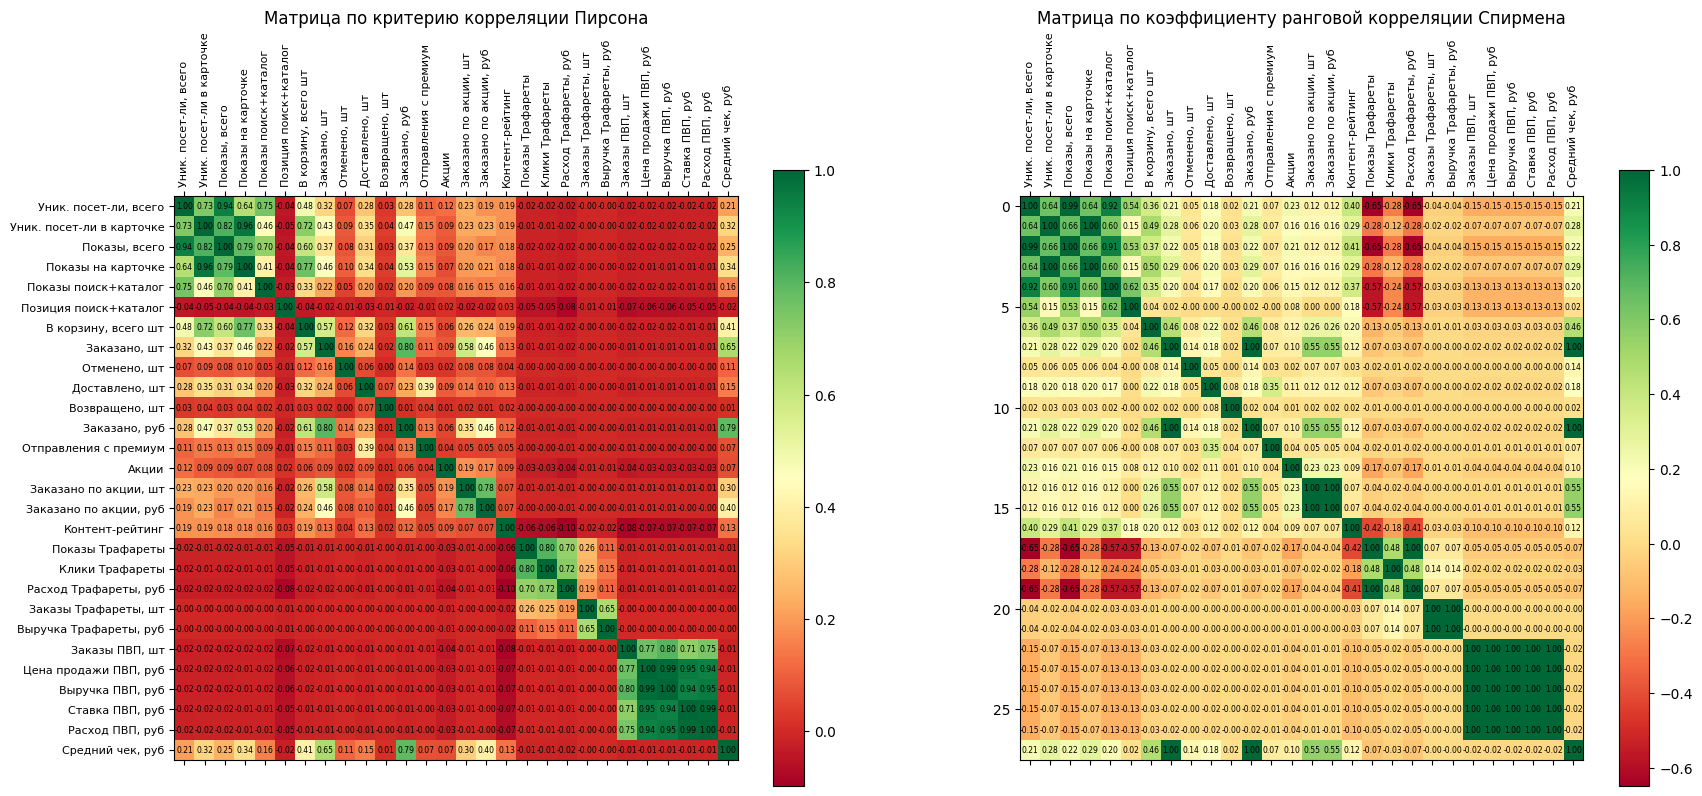

In [ ]:
# Построение тепловой карты
lbls = ['Уник. посет-ли, всего',
     'Уник. посет-ли в карточке',
     'Показы, всего',
     'Показы на карточке',
     'Показы поиск+каталог',
     'Позиция поиск+каталог',
     'В корзину, всего шт',
     'Заказано, шт',
     'Отменено, шт',
     'Доставлено, шт',
     'Возвращено, шт',
     'Заказано, руб',
     'Отправления с премиум',
     'Акции',
     'Заказано по акции, шт',
     'Заказано по акции, руб',
     'Контент-рейтинг',
     'Показы Трафареты',
     'Клики Трафареты',
     'Расход Трафареты, руб',
     'Заказы Трафареты, шт',
     'Выручка Трафареты, руб',
     'Заказы ПВП, шт',
     'Цена продажи ПВП, руб',
     'Выручка ПВП, руб',
     'Ставка ПВП, руб',
     'Расход ПВП, руб',
     'Средний чек, руб']

# Лейблы оси X
x = lbls

# Лейблы оси Y
y = lbls

fig, axes = plt.subplots(ncols=2, figsize=(20, 8))
ax1, ax2 = axes
im1 = ax1.matshow(np_ozon_data_corr_matrixP, cmap='RdYlGn')
im2 = ax2.matshow(np_ozon_data_corr_matrixS, cmap='RdYlGn')

ax1.set_xticks(np.arange(len(x)), labels=x)                                     # Отрисовка делений и подписей к делениям
ax1.set_yticks(np.arange(len(y)), labels=y)
ax2.set_xticks(np.arange(len(x)), labels=x)
plt.setp(ax1.get_xticklabels(), rotation=90, fontsize=8)                        # Параметры для подписей делений
plt.setp(ax1.get_yticklabels(), fontsize=8)
plt.setp(ax2.get_xticklabels(), rotation=90, fontsize=8)

for i in range(len(y)):                                                         # Подписи данных
    for j in range(len(x)):
        text = ax1.text(j, i, '{0:0.2f}'.format(np_ozon_data_corr_matrixP[i, j]),
                       ha="center", va="center", color="black", fontsize=5.5)

for i in range(len(y)):
    for j in range(len(x)):
        text = ax2.text(j, i, '{0:0.2f}'.format(np_ozon_data_corr_matrixS[i, j]),
                       ha="center", va="center", color="black", fontsize=5.5)

fig.colorbar(im1)
fig.colorbar(im2)

ax1.set_title('Матрица по критерию корреляции Пирсона')
ax2.set_title('Матрица по коэффициенту ранговой корреляции Спирмена')

#### Выводы по корреляции

**Коэффициент корреляции** - это статистическая мера силы взаимосвязи между относительными движениями двух переменных. Диапазон значений от -1,0 до 1,0. Корреляция -1,0 показывает идеальную отрицательную корреляцию (обратная зависимость), а корреляция 1,0 показывает идеальную положительную корреляцию (прямая зависимость). Корреляция 0,0 показывает отсутствие линейной зависимости между движением двух переменных

**Корреляция Пирсона может оценивать ТОЛЬКО линейную связь между двумя непрерывными переменными** (зависимость является линейной только тогда, когда изменение одной переменной связано с пропорциональным изменением другой переменной)

*Другими словами, коэффициент корреляции Пирсона следует применять на натуральных и стоимостных показателях*

**Корреляция Спирмена может оценивать монотонную связь между двумя переменными** - непрерывной или порядковой, и она основана на ранжированных значениях для каждой переменной, а не на необработанных данных

>*Что такое монотонные отношения?*
>
>Монотонные отношения - это отношения, выполняющие одно из следующих действий:
>
>(1) по мере увеличения значения одной переменной увеличивается и значение другой переменной, ИЛИ,
>
>(2) по мере увеличения значения одной переменной значение другой переменной уменьшается.
>
>НО, не совсем с постоянной скоростью, тогда как в линейной зависимости скорость увеличения / уменьшения постоянна

*Другими словами, если данные представляют собой ранжированные значения, необходимо использовать коэффициент корреляции Спирмена*

Для оценки тесноты, или силы, корреляционной связи обычно используют общепринятые критерии, согласно которым абсолютные значения коэффициента корреляции Пирсона rxy < 0.3 свидетельствуют о слабой связи, значения rxy от 0.3 до 0.7 - о связи средней тесноты, значения rxy > 0.7 - о сильной связи.

Более точную оценку силы корреляционной связи можно получить, если воспользоваться таблицей Чеддока:

In [ ]:
# Визуализация таблицы Чеддока
cheddock = pd.DataFrame([['менее 0.3', 'слабая'],
                         ['от 0.3 до 0.5', 'умеренная'],
                         ['от 0.5 до 0.7', 'заметная'],
                         ['от 0.7 до 0.9', 'высокая'],
                         ['более 0.9', 'весьма высокая']],
                        columns=['Абсолютное значение rxy', 'Теснота (сила) корреляционной связи'])
display(cheddock)

,Абсолютное значение rxy,Теснота (сила) корреляционной связи
0,менее 0.3,слабая
1,от 0.3 до 0.5,умеренная
2,от 0.5 до 0.7,заметная
3,от 0.7 до 0.9,высокая
4,более 0.9,весьма высокая


Для оценки силы корреляционной связи по коэффициенту ранговой корреляции Спирмена можно, как и в случае коэффициента корреляции Пирсона, воспользоваться таблицей Чеддока

**Стоимостные и натуральные показатели** оценваю по коэффициенту корреляции Пирсона.

Их можно разделить на несколько групп по отношению к воронке продаж:

**Группа показателей по органической воронке продаж** (без платного продвижения)
1. Уникальные посетители, всего;
2. Уникальные посетители в карточке;
3. Показы, всего;
4. Показы на карточке;
5. Показы поиск+каталог;
6. В корзину, всего шт;
7. Заказано, шт;
8. Отменено, шт;
9. Доставлено, шт;
10. Возвращено, шт;
11. Заказано, руб;
12. Отправления с премиум;
13. Средний чек, руб



Основная к выявлению зависимость в цепочке *Уникальные посетители всего - Заказы, шт* показывает умеренно-слабую зависимость (коэффициент корреляции 0.32)

При этом в цепочке *Уникальные посетители всего - В корзину, шт* показывает умеренную корреляцию (0.48)

Если рассмотреть корреляцию *Уникальные посетители с просмотром карточки - В корзину, шт*, то коэффициент выглядит многообещающе - 0.72, что говорит о высокой зависимости. Другими словами, если довести пользователя до просмотра карточки, он с высокой вероятностью добавит товар в корзину.

Показатели *В корзину - Заказано, шт* показывают заметную корреляцию (коэффициент 0.57). Можно предположить, что часть заказов не были оплачены из корзины по причине того, что пользователь параллельно нашел другой более интересный для себя вариант, либо забыл про корзину и не заказал товар совсем. К сожалению, на имеющихся данных исследовать подробно этот вопрос нет возможности

Для связки *Заказано, шт - Доставлено, шт* коэффициент корреляции Пирсона составил всего 0.24, что означает слабую зависимость. Это говорит о том, что выкупается мало заказов в сравнении с заказанными, и много заказов отменяется или возвращается.

Причины для этого могут быть разные, именно в этой связи я вижу точку роста

**Группа показателей по воронке продаж с продвижением через акции** на маркетплейсе
1. Заказано по акции, шт;
2. Заказано по акции, руб

Показатели имеют заметную корреляцию относительно Заказно, шт (то есть всех заказанных товаров), что может говорить о том, что участие в акции помогает получать больше заказов продавцу

**Группа показателей по воронке продаж с продвижением через Трафареты** (вид рекламной кампании на Озон)
1. Показы Трафареты;
2. Клики Трафареты;
3. Расход Трафареты, руб;
4. Заказы Трафареты, шт;
5. Выручка Трафареты, руб

Данную группу показателей целесообразно оценивать внутри собственной воронки от показов до заказов и выручки

Основная к выявлению зависимость Показы - Заказы Трафареты, шт показывает слабую зависимость с коэффициентом корреляции 0.26

При этом Расход на рекламные кампании в Трафаретах сильно влияют на Показы и Клики в трафаретах (0.70 и 0.72 соответственно), а вот на Заказы слабо (коэффициент корреляции 0.19)

Складывается впечатление, что контент в рекламе обещал пользователям не совсем то, что они видели в карточке товара. То есть рекламный оффер их привлекал, но товар в итоге они не заказывали. Либо товар пользователю интересен, но покупку он отложил до лучших времен

**Группа показателей по воронке продаж с продвижением через Продвижение в поиске** (вид рекламной кампании на Озон)
1. Заказы ПВП, шт;
2. Цена продажи ПВП, руб;
3. Выручка ПВП, руб;
4. Ставка ПВП, руб;
5. Расход ПВП, руб

Данную группу показателей также целесообразно оценивать внутри собственной воронки от показов до заказов и выручки по продвижению в поиске

Здесь, в отличие от Трафаретов, коэффициенты корреляции очень высокие по всем показателям между собой. То есть можно говорить о том, что данный метод продвижения работает хорошо, и расходы на рекламу напрямую влияют на количество заказов



---

Рассматривая два метода платного продвижения есть гипотеза, что через Трафареты (1) пользователи обычно совершают спонтанные покупки, а спонтанность не свойственна для покупок в рассматриваемых категориях товаров в автомобильной тематике. Зато продвижение в поиске (2) дает хорошие результаты, так как путь пользователя к покупке скорее всего идет через поиск конкретного товара, подходящего к определенным маркам авто, и данный вид продвижения обеспечивает более высокую позицию в поиске

*Справочно, [источник](https://seller-edu.ozon.ru/how-to-sell-effectively/advertising-of-goods/reklama-tovarov)*


> **(1) Трафареты** — это инструмент автоматической настройки продвижения товаров в поиске, категориях, карточках товара и других страницах Ozon:
>
> *  на страницах выдачи поиска и категорий, на страницах промо-подборок товаров;
>
> *  на третьей и последующих страницах выдачи — в блоке над поисковой выдачей на сайте или в мобильном приложении;
>
> *  в рекомендательных полках:
>
> *  в карточках товаров;
>
> *  в корзине;
>
> *  на сайте — на странице оформленного заказа;
>
> *  после оплаты заказа;
>
> *  на сайте — на странице заказа;
>
> *  в приложении — в отзывах и вопросах.
>
> *  на главном экране в приложении «Возможно вам понравится» — пока видят не все покупатели


> **(2) Продвижение в поиске** — инструмент, который помогает повысить позицию в поиске. Берём оплату за заказы товаров с продвижением




---



**Ранжированные показатели** (полученные через вычисление ранга, присвоения баллов, оценок и тп.) оцениваю через коэффициент корреляции Спирмена.

К таким показателям отношу:
1. Контент-рейтинг;
2. Акции (наличие/отсутствие акции в день рассмотрения);
3. Позиция в поиске и каталоге


Показатель контент-рейтинг формируется маркетплейсом и отражает множество факторов заполненности карточки товара контентом

Предполагается, что чем выше контент-рейтинг, тем карточка товара может быть более релевантной относительно поискового запроса пользователя на маркетплейсе

В подтверждение вышесказанного, наблюдается умеренная связь по коэффициенту корреляции Спирмена между Контент-рейтингом и показателями, отвечающими за показы всего и показы в поиске и каталоге

Несмотря на это, доверие к данному показателю низкое, так как контент-рейтинг по логике должен изменяться во времени в зависимости от того, как пользователь мог наполнять контентом карточку постепенно, а также сам маркетплейс Озон сообщает, что существует вероятность добавления новых характеристик в уже заполненную карточку, что снижает контент-рейтинг товара, пока новые характеристики не будут заполнены

Справочно, [источник](https://seller-edu.ozon.ru/work-with-goods/reference-goods/content-rating)

> **Контент-рейтинг** — это рекомендация по заполнению необязательных характеристик товара, которая поможет сделать его более привлекательным для покупателей. Чем больше рейтинг, тем выше вероятность, что покупатели выберут именно ваш товар
>
> Контент-рейтинг не гарантирует увеличение продаж. Важную роль играет заполненность поисковых характеристик — так выше вероятность, что вы попадёте в конкретный запрос покупателя
>
> Этот показатель помогает заполнить карточку товара
>
> Иногда мы добавляем новые характеристики уже после того, как вы заполнили карточки товаров — тогда контент-рейтинг может уменьшиться. Чтобы узнать, какие атрибуты добавились и повысить значение рейтинга, откройте режим редактирования товара или окно контент-рейтинга — там появятся новые незаполненные характеристики

По показателю Акция (из расчета 1 при наличии акции на дату, 0 отсутствие Акции на дату) не выявлено значимой связи с другими показателями. Это может быть связано с методом расчета показателя

По показателю Позиция в поиске и каталоге мной ожидалась обратная корреляция (отрицательные коэффициенты), то есть при уменьшении позиции в поиске остальные показатели предположительно должны были расти, и наборот. То есть чем меньше число Позиция в поиске и каталоге, тем товар выше в выдаче поиска, тем больше должно быть Показов (по информации от маркетплейса Озон)

Данный показатель действительно имеет заметную зависимость по коэффициенту корреляции Спирмена к показателям, относящимся к поиску - Показы всего, Показы в поиске и каталоге (0.52 и 0.62) соответственно. Но зависимость должна быть обратной, и коэффициенты корреляции должны были быть отрицательными, как в случае связки Позиция в поиске - Показы Трафареты (-0.57)

В связи с вышесказанным, считаю, что опираться на показатель Позиция в поиске и каталоге нельзя

#3 Эксперименты

##3.1 Сервисные функции

Опишем сервисные функции, которые упростят дальнейшие эксперименты с архитектурами НС:

get_pred() – обученная модель. Предсказывает результат, который возвращается к ненормированным данным;

correlate() – расчет коэффициента автокорреляции;

show_predict() – построение графиков предсказания и верных ответов;

show_corr() – построение графика автокорреляции;

eval_net() – объединяет предыдущие функции и показывает результаты обучения сети;

train_eval_net() – процесс обучения сети и вывод ее результатов. В обучении модели подаются не отдельные выборки, а сразу генераторы, так как они дают тот же результат, что и отдельные выборки. При этом уже нет необходимости прописывать размер батча обучения, поскольку он прописан в самом генераторе.

In [ ]:
#Устанавливаю для сервисных функций переменную
CHANNEL_Y = ['Заказано в шт']

In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [ ]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

In [ ]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=10, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''): # список имен каналов данных

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=10, # параметры отображения графиков
             title=''):

    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max,
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [ ]:
# Функция обучения модели и отрисовки прогресса и оценки результатов

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=10,
                   title=''):

    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

##3.2 Подготовка данных

Далее будет проводиться серия экспериментов по предсказанию продаж на маркетплейсах

Эксперименты будут отличаться не только по гиперпараметрам сети, но и по подаваемым данным

Так, в Эксперименте 1 данные будут сгруппированы по одном дню, в эксперименте 2 по двум дням, в эксперименте 3 по трем дням

Во всех экспериментов из дадасета будут выделены только данные по самой продаваемой категории товаров

В каждом из экспериментов будет тестироваться несколько вариантов наборов каналов, чтобы понять, сколько это помогает или вообще не помогает сети обучаться

In [ ]:
# Проверяю спрос по категориям
ozon_data_cat = ozon_data.groupby(['Категория 3-го уровня']).agg(
                                                                 zakazano_total=('Заказано товаров', 'sum')
)
ozon_data_cat.sort_values('zakazano_total', ascending=False, inplace=True)
ozon_data_cat

,zakazano_total
Категория 3-го уровня,
Фара автомобильная,4397.0
Комплектующие для ксеноновых фар,3311.0
Лампа автомобильная,1503.0
"Автохимия - Герметик, клей",230.0
Фонарь задний для авто,31.0
0,0.0
Другое,0.0
Комплектующие светодиодной лампы для авто,0.0
Разное автопринадлежности,0.0


Больше всего заказов было по трем категориям: Фара автомобильная, Комплектующие для ксеноновых фар, Лампа автомобильная

Далее беру данные по категории Фара автомобильная

In [ ]:
# Выбираю строки по категории Фара автомобильная
ozon_data_fara = ozon_data.loc[ozon_data['Категория 3-го уровня'] == 'Фара автомобильная']
ozon_data_fara.fillna(0, inplace=True)
ozon_data_fara.head(10)

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2022-06-01,Фара автомобильная,"Стекла на фары Mazda 6 gg 2004-2008, комплект ...",0,556907762,30108,3.0,1.0,6.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,Фара автомобильная,"Линзы для фар GNX Hella 3R H7, D2S","Линзы для фар GNX Hella 3R H7, D2S",480448445,29140,222.0,25.0,416.0,47.0,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2100.0
2022-06-01,Фара автомобильная,"Стекло фары Mazda 3 BM 2017-2019, левое, GNX, ...",0,511572300,29328,5.0,0.0,6.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,Фара автомобильная,"Стекло фары Mercedes ML W164 2005-2008, левое,...",0,522646905,30258,6.0,0.0,8.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,Фара автомобильная,"Стекло фары Mercedes W207 Coupe 2013-2016, пра...",0,522646914,30929,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,Фара автомобильная,"Стекло фары, GNX, левое, поликарбонат, для авт...",0,522646908,29338,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,Фара автомобильная,"Стекла на фары Audi Q5 2008-2012, комплект (ле...",0,511573452,30046,2.0,0.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,Фара автомобильная,"Стекло фары Mazda 6 GH (2007 - 2012), правое, ...",0,511572010,26718,158.0,3.0,245.0,5.0,116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0
2022-06-01,Фара автомобильная,"Стекло фары Audi A6 C7 2014-2018, левое, GNX, ...",0,522646927,28576,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Бэкап до удаления столбцов
backup_ozon_data_fara = ozon_data_fara.copy()

In [ ]:
#ozon_data_fara = backup_ozon_data_fara.copy()

In [ ]:
# Удаление текстовых столбцов и столбцов с низкой корреляцией по показателям
ozon_data_fara.drop(['Категория 3-го уровня',
                     'Товары', 'Модель',
                     'Ozon ID', 'Артикул',
                     'Акции',
                     'Отправления с премиум-подпиской, принятые в обработку',
                     'Контент-рейтинг',
                     'Позиция в поиске и каталоге'], axis=1, inplace=True)
ozon_data_fara.head()

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2022-06-01,3.0,1.0,6.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,222.0,25.0,416.0,47.0,164.0,3.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2100.0
2022-06-01,5.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,6.0,0.0,8.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ozon_data_fara.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90568 entries, 2022-06-01 to 2023-05-31
Data columns (total 24 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Уникальные посетители, всего                        90568 non-null  float64
 1   Уникальные посетители с просмотром карточки товара  90568 non-null  float64
 2   Показы, всего                                       90568 non-null  float64
 3   Показы на карточке товара                           90568 non-null  float64
 4   Показы в поиске и каталоге                          90568 non-null  float64
 5   В корзину, всего                                    90568 non-null  float64
 6   Заказано товаров                                    90568 non-null  float64
 7   Отменено товаров                                    90568 non-null  float64
 8   Доставлено (за выбранный период)                    90568 n

##Эксперимент 2

Для эксперимента 2 группирую данные по два дня

In [ ]:
# Группирую данные по дням
fara = ozon_data_fara.groupby(pd.Grouper(freq='2D')).agg({'Уникальные посетители, всего':'sum',
                                                          'Уникальные посетители с просмотром карточки товара':'sum',
                                                          'Показы, всего':'sum',
                                                          'Показы на карточке товара':'sum',
                                                          'Показы в поиске и каталоге':'sum',
                                                          'В корзину, всего':'sum',
                                                          'Заказано товаров':'sum',
                                                          'Отменено товаров':'sum',
                                                          'Доставлено (за выбранный период)':'sum',
                                                          'Возвращено товаров':'sum',
                                                          'Заказано на сумму':'sum',
                                                          'Заказано товаров по акции':'sum',
                                                          'Заказано на сумму по акции':'sum',
                                                          'Показы Трафареты':'sum',
                                                          'Клики Трафареты':'sum',
                                                          'Расход Трафареты':'sum',
                                                          'Заказы Трафареты':'sum',
                                                          'Выручка Трафареты':'sum',
                                                          'Заказы ПВП':'sum',
                                                          'Цена продажи ПВП':'mean',
                                                          'Выручка ПВП':'sum',
                                                          'Ставка ПВП':'mean',
                                                          'Расход ПВП':'sum',
                                                          'Средний чек':'mean'})


fara.head(10)

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2022-06-01,6254.0,349.0,9067.0,540.0,4644.0,80.0,11.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.400576
2022-06-03,6282.0,323.0,8809.0,451.0,4541.0,50.0,5.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.060440
2022-06-05,7622.0,365.0,10818.0,535.0,5815.0,68.0,5.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.034884
2022-06-07,8639.0,427.0,12197.0,626.0,6716.0,65.0,5.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.927461
2022-06-09,6794.0,338.0,9938.0,506.0,5099.0,49.0,6.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.021108
2022-06-11,6786.0,355.0,9814.0,499.0,5424.0,47.0,7.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.536873
2022-06-13,8576.0,418.0,12506.0,642.0,6663.0,69.0,6.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.692098
2022-06-15,9908.0,395.0,14144.0,582.0,7287.0,69.0,6.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.320856
2022-06-17,7111.0,321.0,9957.0,456.0,5686.0,63.0,6.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.334218


In [ ]:
# Переформирую средний чек
fara.drop('Средний чек', axis=1, inplace=True)
fara['Средний чек'] = fara['Заказано на сумму'] / fara['Заказано товаров']
fara.head(10)

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2022-06-01,6254.0,349.0,9067.0,540.0,4644.0,80.0,11.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3577.272727
2022-06-03,6282.0,323.0,8809.0,451.0,4541.0,50.0,5.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2698.000000
2022-06-05,7622.0,365.0,10818.0,535.0,5815.0,68.0,5.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5300.000000
2022-06-07,8639.0,427.0,12197.0,626.0,6716.0,65.0,5.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3700.000000
2022-06-09,6794.0,338.0,9938.0,506.0,5099.0,49.0,6.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3665.000000
2022-06-11,6786.0,355.0,9814.0,499.0,5424.0,47.0,7.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3628.571429
2022-06-13,8576.0,418.0,12506.0,642.0,6663.0,69.0,6.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3783.333333
2022-06-15,9908.0,395.0,14144.0,582.0,7287.0,69.0,6.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2825.000000
2022-06-17,7111.0,321.0,9957.0,456.0,5686.0,63.0,6.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3916.666667


In [ ]:
#Переустанавливаю индекс, так как данные уже были отсортированы по времени
fara.reset_index(inplace=True)
fara.drop('День', axis=1, inplace=True)
fara.head()

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
0,6254.0,349.0,9067.0,540.0,4644.0,80.0,11.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3577.272727
1,6282.0,323.0,8809.0,451.0,4541.0,50.0,5.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2698.000000
2,7622.0,365.0,10818.0,535.0,5815.0,68.0,5.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5300.000000
3,8639.0,427.0,12197.0,626.0,6716.0,65.0,5.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3700.000000
4,6794.0,338.0,9938.0,506.0,5099.0,49.0,6.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3665.000000


In [ ]:
# Проверяю на пустоту
fara.isna().sum()

Уникальные посетители, всего                          0
Уникальные посетители с просмотром карточки товара    0
Показы, всего                                         0
Показы на карточке товара                             0
Показы в поиске и каталоге                            0
В корзину, всего                                      0
Заказано товаров                                      0
Отменено товаров                                      0
Доставлено (за выбранный период)                      0
Возвращено товаров                                    0
Заказано на сумму                                     0
Заказано товаров по акции                             0
Заказано на сумму по акции                            0
Показы Трафареты                                      0
Клики Трафареты                                       0
Расход Трафареты                                      0
Заказы Трафареты                                      0
Выручка Трафареты                               

In [ ]:
# Заменяю nan на 0
fara.fillna(0, inplace=True)
fara.head()

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,...,Клики Трафареты,Расход Трафареты,Заказы Трафареты,Выручка Трафареты,Заказы ПВП,Цена продажи ПВП,Выручка ПВП,Ставка ПВП,Расход ПВП,Средний чек
0,6254.0,349.0,9067.0,540.0,4644.0,80.0,11.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3577.272727
1,6282.0,323.0,8809.0,451.0,4541.0,50.0,5.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2698.000000
2,7622.0,365.0,10818.0,535.0,5815.0,68.0,5.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5300.000000
3,8639.0,427.0,12197.0,626.0,6716.0,65.0,5.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3700.000000
4,6794.0,338.0,9938.0,506.0,5099.0,49.0,6.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3665.000000


In [ ]:
# Перевожу в numpy массив
np_fara = fara.values
print(np_fara.shape)
print(np_fara[0])

(183, 24)
[6.25400000e+03 3.49000000e+02 9.06700000e+03 5.40000000e+02
 4.64400000e+03 8.00000000e+01 1.10000000e+01 1.00000000e+00
 1.10000000e+01 0.00000000e+00 3.93500000e+04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.57727273e+03]


In [ ]:
fara.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 24 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Уникальные посетители, всего                        183 non-null    float64
 1   Уникальные посетители с просмотром карточки товара  183 non-null    float64
 2   Показы, всего                                       183 non-null    float64
 3   Показы на карточке товара                           183 non-null    float64
 4   Показы в поиске и каталоге                          183 non-null    float64
 5   В корзину, всего                                    183 non-null    float64
 6   Заказано товаров                                    183 non-null    float64
 7   Отменено товаров                                    183 non-null    float64
 8   Доставлено (за выбранный период)                    183 non-null    float64
 9  

In [ ]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Уникальные посетители',
                 'Уникальные посетители в карточке',
                 'Показы',
                 'Показы на карточке',
                 'Показы поиск + каталог',
                 'В корзину',
                 'Заказано в шт',
                 'Отменено',
                 'Доставлено',
                 'Возвращено',
                 'Заказано в руб',
                 'Заказано в шт по акции',
                 'Заказано в руб по акции',
                 'Показы Трафареты',
                 'Клики Трафареты',
                 'Расход Трафареты',
                 'Заказы Трафареты',
                 'Выручка Трафареты',
                 'Заказы ПВП',
                 'Цена продажи ПВП',
                 'Выручка ПВП',
                 'Ставка ПВП',
                 'Расход ПВП',
                 'Средний чек']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX)

{'Уникальные посетители': 0, 'Уникальные посетители в карточке': 1, 'Показы': 2, 'Показы на карточке': 3, 'Показы поиск + каталог': 4, 'В корзину': 5, 'Заказано в шт': 6, 'Отменено': 7, 'Доставлено': 8, 'Возвращено': 9, 'Заказано в руб': 10, 'Заказано в шт по акции': 11, 'Заказано в руб по акции': 12, 'Показы Трафареты': 13, 'Клики Трафареты': 14, 'Расход Трафареты': 15, 'Заказы Трафареты': 16, 'Выручка Трафареты': 17, 'Заказы ПВП': 18, 'Цена продажи ПВП': 19, 'Выручка ПВП': 20, 'Ставка ПВП': 21, 'Расход ПВП': 22, 'Средний чек': 23}


###Иллюстрация данных

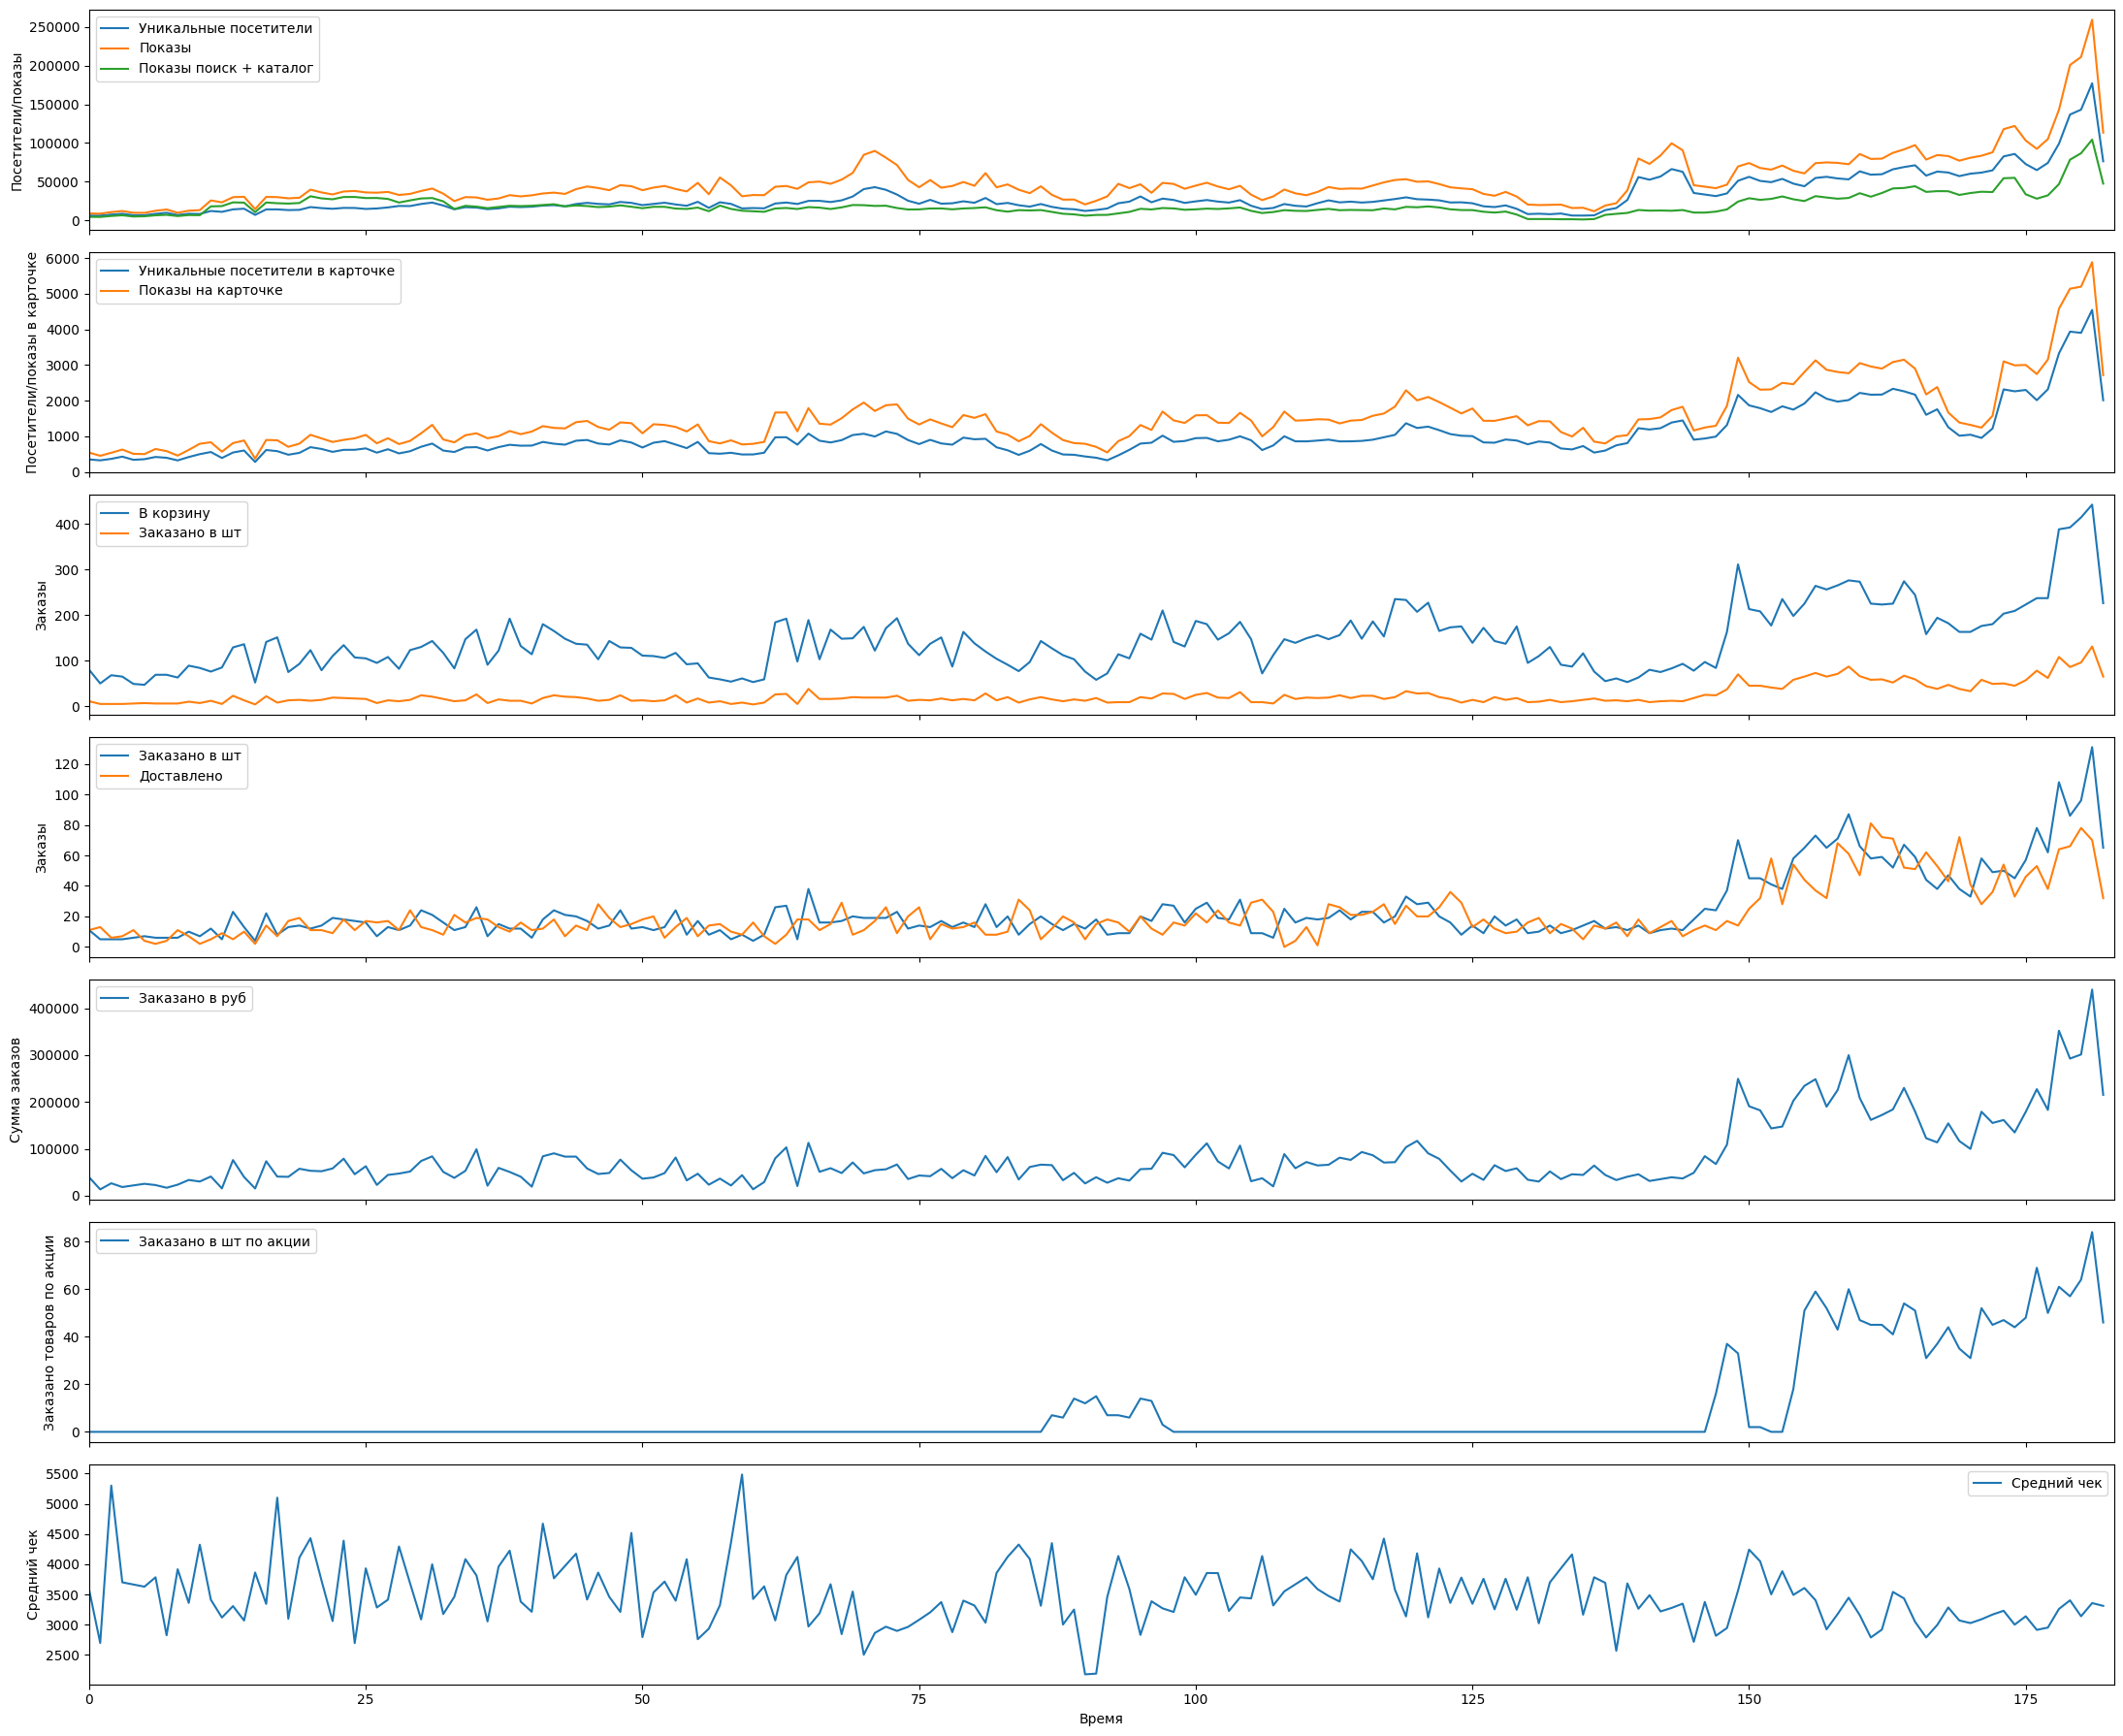

In [ ]:
# Задание полотна для графиков - шесть подграфиков один под другим с общей осью x
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(22, 18), sharex=True)

# Данные по посетителям и показам total
for chn in [0, 2, 4]:
    # Отрисовка канала данных
    ax1.plot(np_fara[0:, chn],
             label=CHANNEL_NAMES[chn])
ax1.set_ylabel('Посетители/показы')
ax1.legend()

# Данные по посетителям и показам в карточке
for chn in [1, 3]:
    # Отрисовка канала данных
    ax2.plot(np_fara[0:, chn],
             label=CHANNEL_NAMES[chn])
ax2.set_ylabel('Посетители/показы в карточке')
ax2.legend()

# Данные по корзине/заказам
for chn in [5, 6]:
    # Отрисовка канала данных
    ax3.plot(np_fara[0:, chn],
             label=CHANNEL_NAMES[chn])
ax3.set_ylabel('Заказы')
ax3.legend()

# Данные по заказам/доставке
for chn in [6, 8]:
    # Отрисовка канала данных
    ax4.plot(np_fara[0:, chn],
             label=CHANNEL_NAMES[chn])
ax4.set_ylabel('Заказы')
ax4.legend()

# Данные по сумме заказов
for chn in [10]:
    # Отрисовка канала данных
    ax5.plot(np_fara[0:, chn],
             label=CHANNEL_NAMES[chn])
ax5.set_ylabel('Сумма заказов')
ax5.legend()

# Данные по заказанным товарам по акции
for chn in [11]:
    # Отрисовка канала данных
    ax6.plot(np_fara[0:, chn],
             label=CHANNEL_NAMES[chn])
ax6.set_ylabel('Заказано товаров по акции')
ax6.legend()

# Данные по заказанным товарам по акции
for chn in [23]:
    # Отрисовка канала данных
    ax7.plot(np_fara[0:, chn],
             label=CHANNEL_NAMES[chn])
ax7.set_ylabel('Средний чек')
ax7.legend()

plt.xlabel('Время')
# Регулировка пределов оси x
plt.xlim(0, len(np_fara))
# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()
# Фиксация графика
plt.show()

Наличие акции в середине графика как будто никак не повлияло на сумму продаж. Второй период ации наоборот коррелирует с увеличением показателей по посетителям и заказам

###Эксперимент 2.1

####Установка гиперпараметров

Чтобы лучше понять, как задать гиперпараметры сети, имитирую выборку, равную по длине подготовленному датасету по каналу 'Заказано в шт'

In [ ]:
print(np_fara.shape)

(183, 24)


In [ ]:
# Создаю последовательность от 0 до 183 в качестве модельного массива, так как даные в изначальном датасете предоставлены за год и сгруппированы по дням,
#что равно длине обработанного датасета
test_array = np.arange(183)
print(test_array)

In [ ]:
# Функция создания пробного генератора и вывода его результатов на экран
# На входе - имитация выборок x_train, y_train
def show_gen_example(x_train, y_train, length=14, batch_size=1):
    # Создание генератора TimeseriesGenerator
    gen = TimeseriesGenerator(x_train,
                              y_train,
                              length=length,
                              sampling_rate=1,
                              stride=1,
                              batch_size=batch_size
                             )

    # Прохождение по элементам генератора (батчам) в цикле и вывод каждого батча
    for i, g in enumerate(gen):
        print('Батч №', i)
        print('x_train:\n', g[0])
        print('y_train:\n', g[1])
        print()

In [ ]:
# Подаю тестовый массив в генератор
# В примере имитируется, что по 28 дням (4 недели) предсказывается следующая за этими днями неделя

x_train = test_array
y_train = [test_array[i:i + 6].tolist() for i in range(test_array.shape[0])]
print(y_train)
print
show_gen_example(x_train, y_train)

In [ ]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Заказано в шт']             # Отбор каналов данных для предсказания
SEQ_LEN = 3                              # Длина прошедших данных для анализа
BATCH_SIZE = 1                            # Объем батча для генератора
TEST_LEN = 21                             # Объем тестовой выборки
TRAIN_LEN = np_fara.shape[0] - TEST_LEN   # Объем обучающей выборки

In [ ]:
print(np_fara.shape[0] - TEST_LEN)

162


####Данные для выборки

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = np_fara[:TRAIN_LEN], np_fara[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] [6]
Train data: (162, 24), (162, 1)
Test  data: (15, 24), (15, 1)
Train batch x: (1, 3, 24), y: (1, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (12, 3, 24), y: (12, 1)


####Полносвязная сетка

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 3, 50)             1250      
                                                                 
 flatten_8 (Flatten)         (None, 150)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 151       
                                                                 
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
Обучение 50 эпох
Epoch 1/50
159/159 [==============================] - 1s 3ms/step - loss: 0.0214 - val_loss: 0.0932
Epoch 2/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0790
Epoch 3/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0819

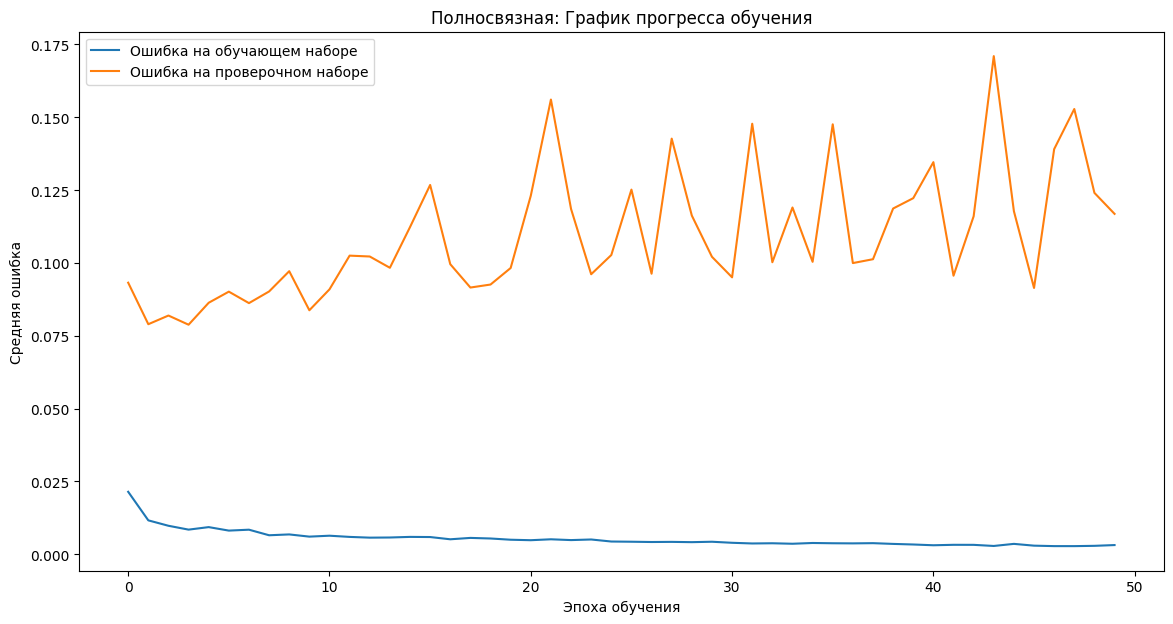

1/1 [==============================] - 0s 83ms/step


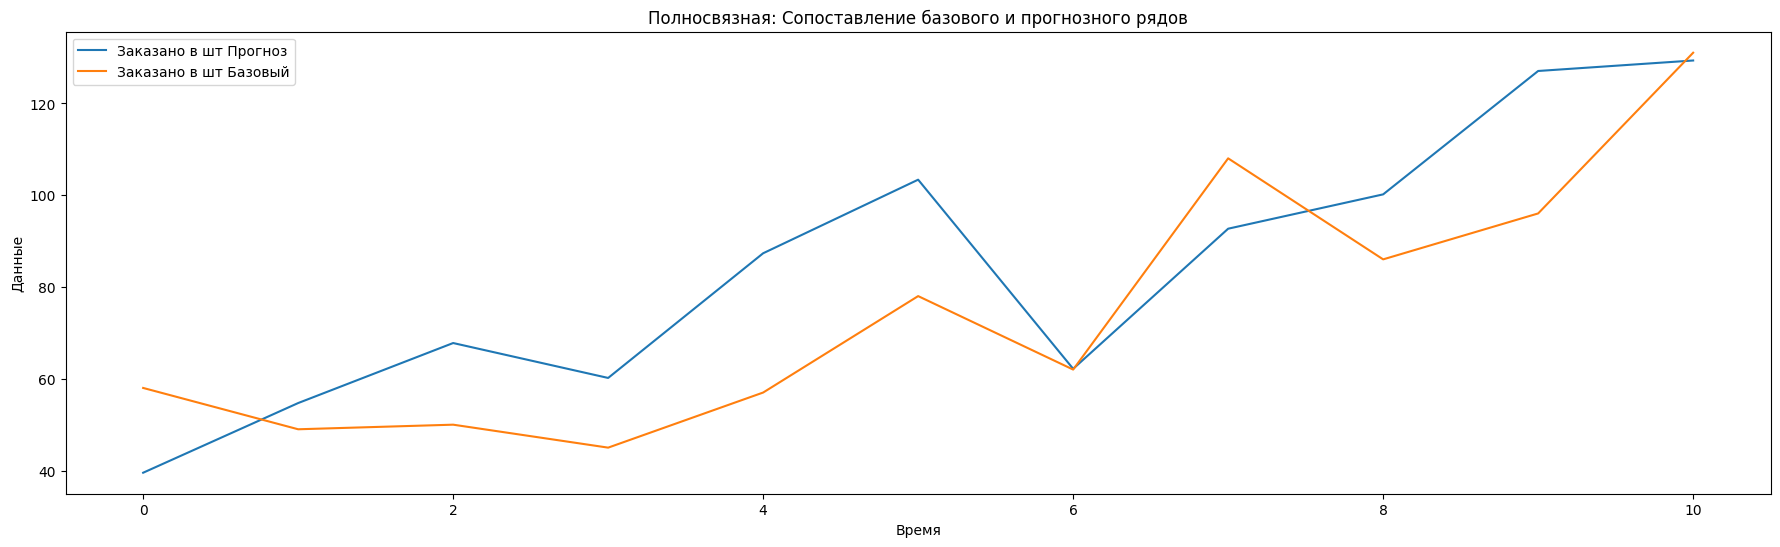

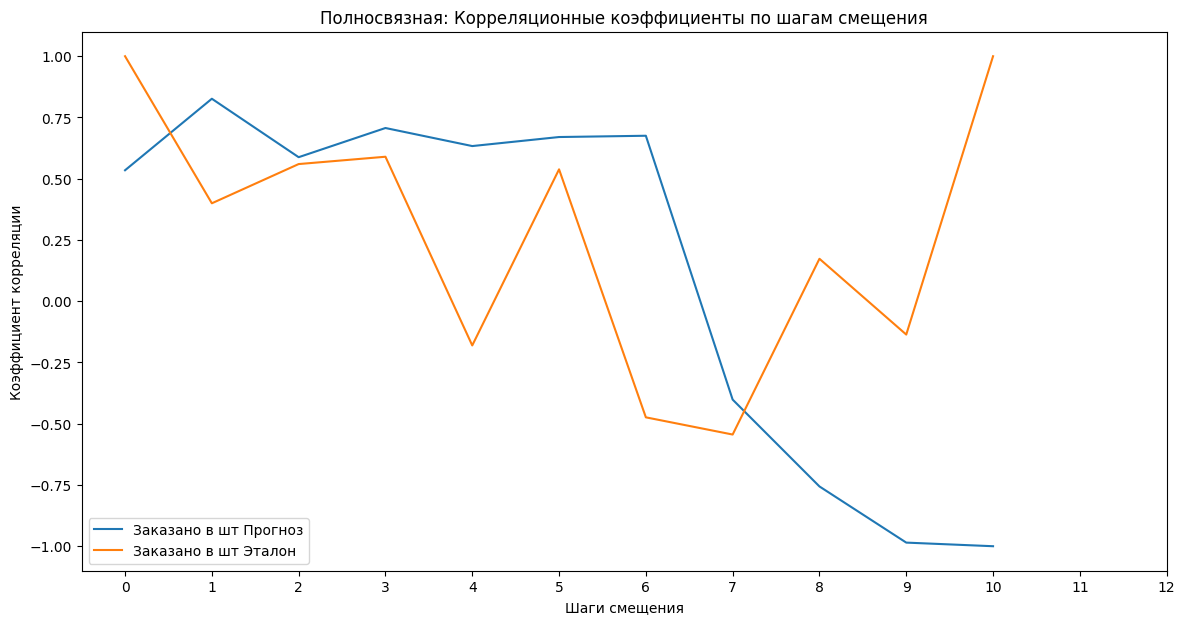

Обучение 50 эпох
Epoch 1/50
159/159 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.1088
Epoch 2/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.1144
Epoch 3/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.1118
Epoch 4/50
159/159 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.1190
Epoch 5/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.1186
Epoch 6/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0970
Epoch 7/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.1061
Epoch 8/50
159/159 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.1089
Epoch 9/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.1098
Epoch 10/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0022 -

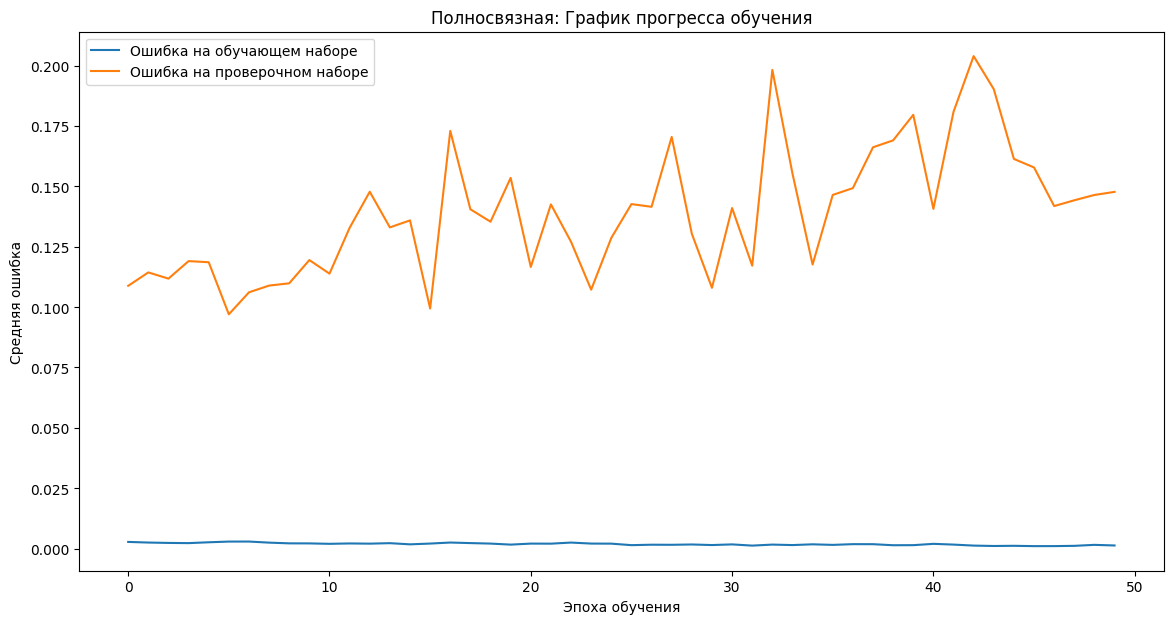

1/1 [==============================] - 0s 91ms/step


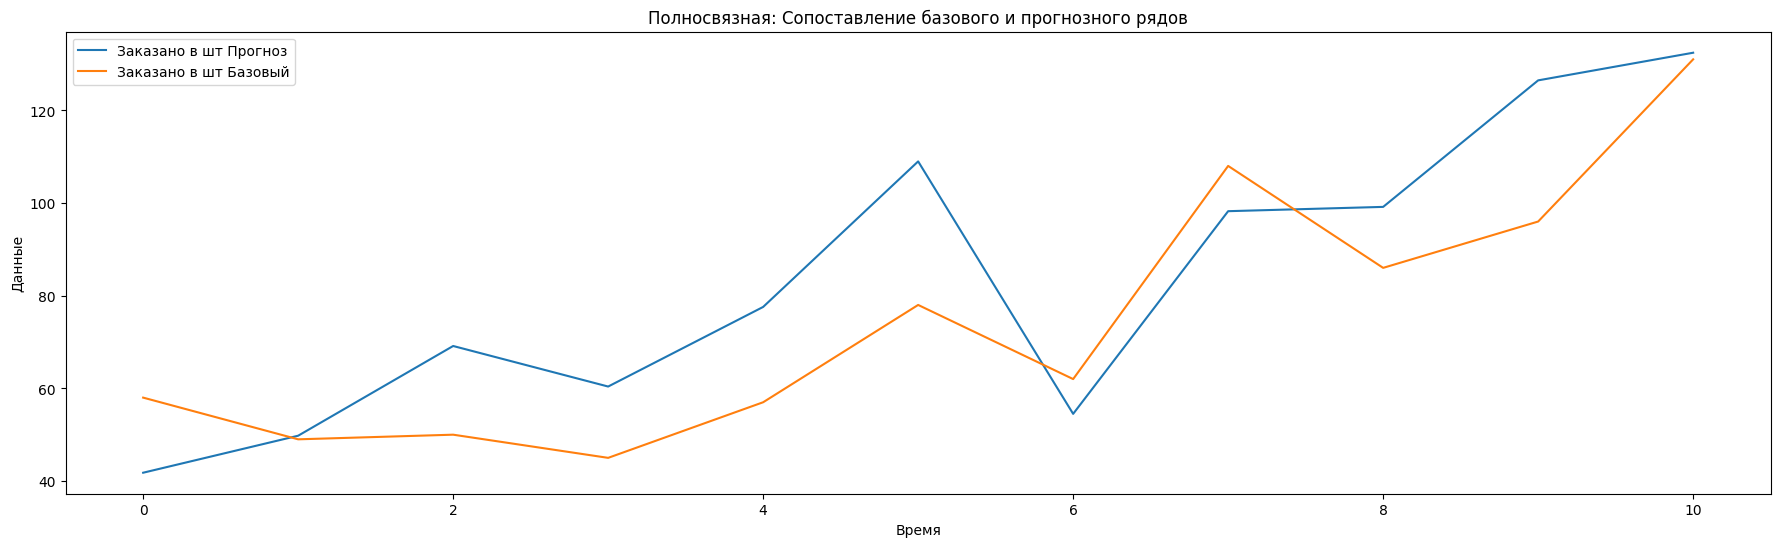

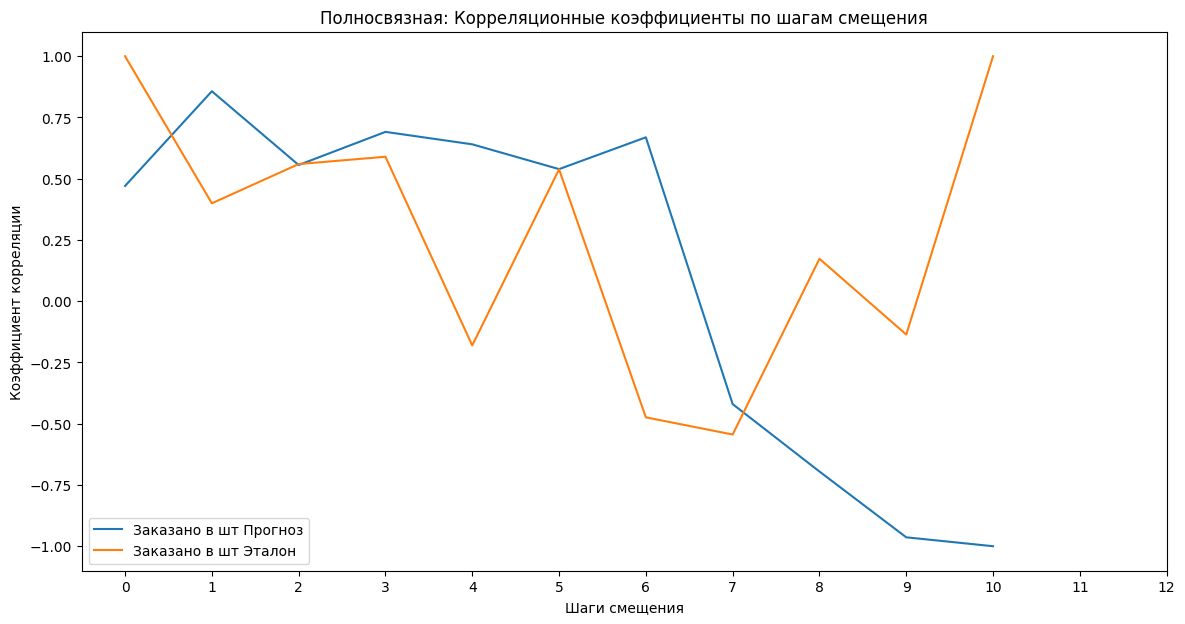

Обучение 50 эпох
Epoch 1/50
159/159 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.2245
Epoch 2/50
159/159 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.1558
Epoch 3/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.1581
Epoch 4/50
159/159 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.1538
Epoch 5/50
159/159 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.1486
Epoch 6/50
159/159 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.1410
Epoch 7/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.1449
Epoch 8/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.1591
Epoch 9/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.1566
Epoch 10/50
159/159 [==============================] - 0s 3ms/step - loss: 0.0010 -

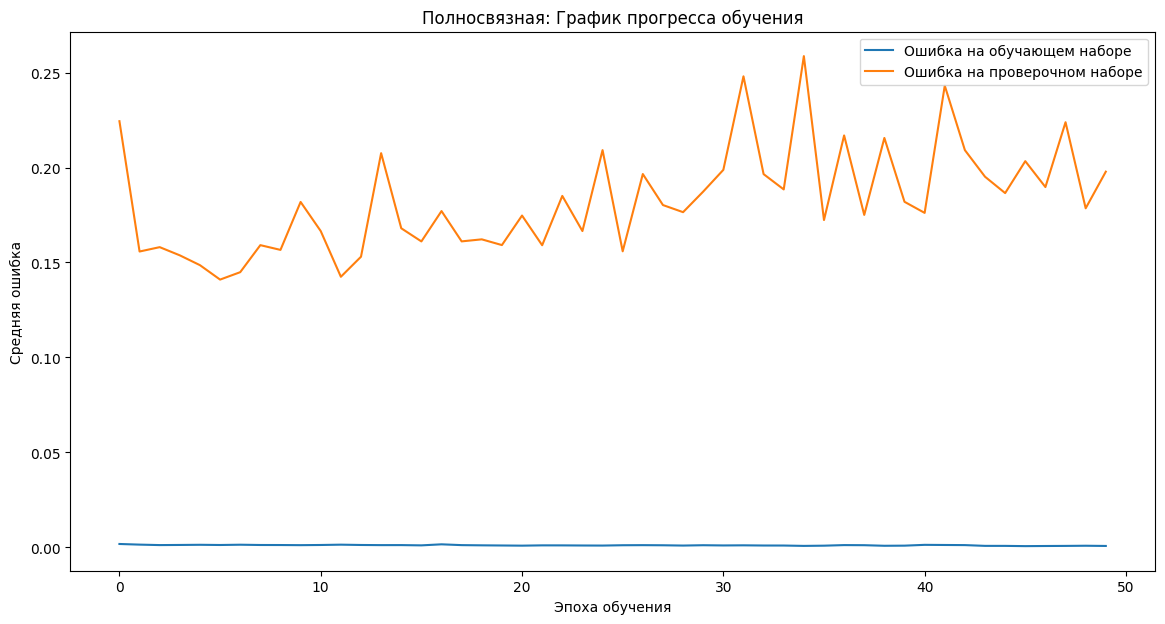

1/1 [==============================] - 0s 85ms/step


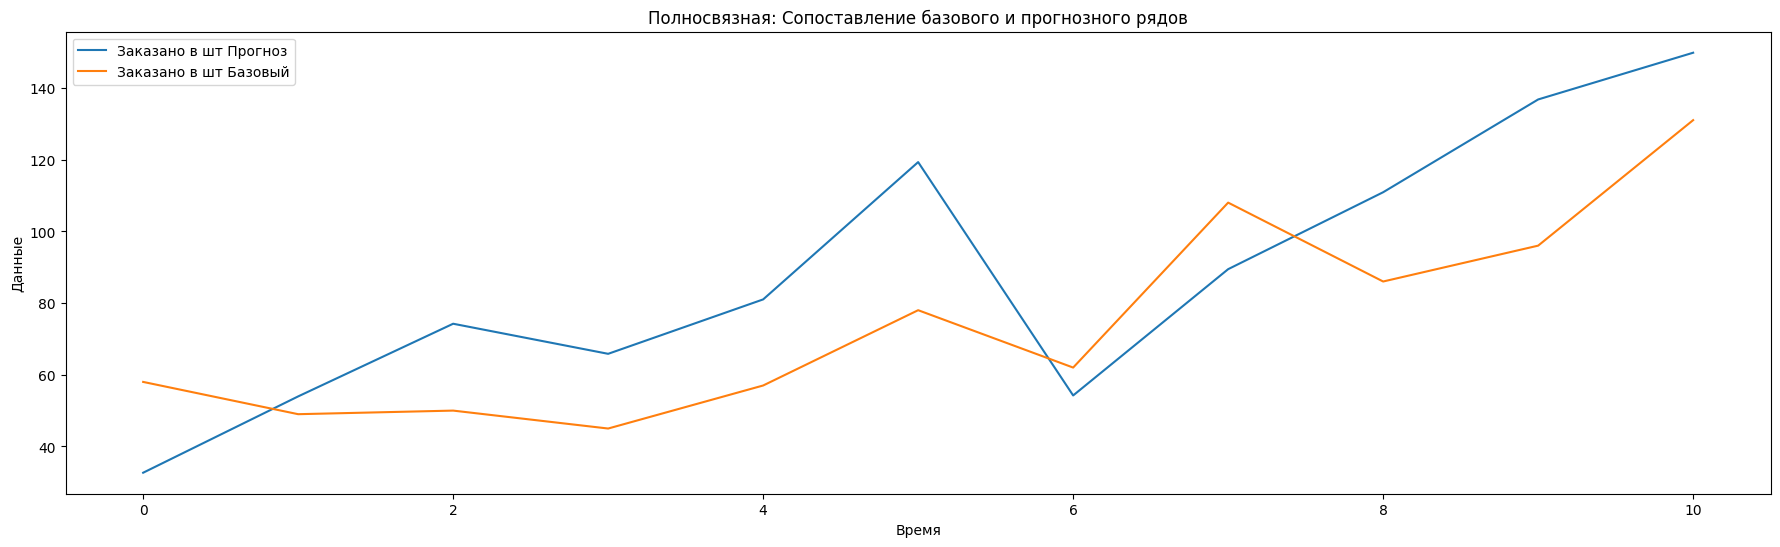

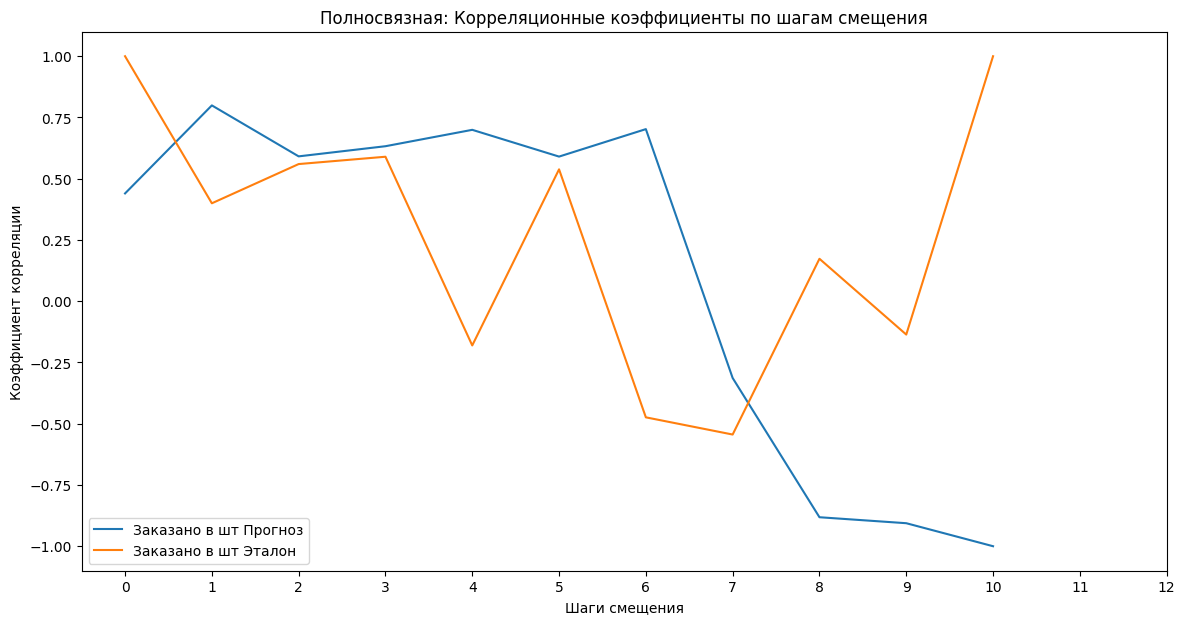

In [ ]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(50, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 3x50 эпох
train_eval_net(model_dense, train_datagen, val_datagen, [(50, Adam(lr=1e-4)), (50, Adam(lr=1e-5)), (50, Adam(lr=1e-6))], x_test, y_test, y_scaler, title='Полносвязная')

###Эксперимент 2.2

####Установка гиперпараметров

In [ ]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Заказано в шт']             # Отбор каналов данных для предсказания
SEQ_LEN = 7                               # Длина прошедших данных для анализа
BATCH_SIZE = 1                            # Объем батча для генератора
TEST_LEN = 30                             # Объем тестовой выборки
TRAIN_LEN = np_fara.shape[0] - TEST_LEN   # Объем обучающей выборки

In [ ]:
print(np_fara.shape[0] - TEST_LEN)

153


####Данные для выборки

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = np_fara[:TRAIN_LEN], np_fara[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] [6]
Train data: (153, 24), (153, 1)
Test  data: (16, 24), (16, 1)
Train batch x: (1, 7, 24), y: (1, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (9, 7, 24), y: (9, 1)


####Полносвязная сетка

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 7, 50)             1250      
                                                                 
 flatten_9 (Flatten)         (None, 350)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 351       
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
Обучение 50 эпох
Epoch 1/50
146/146 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.1240
Epoch 2/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.1552
Epoch 3/50
146/146 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.1495

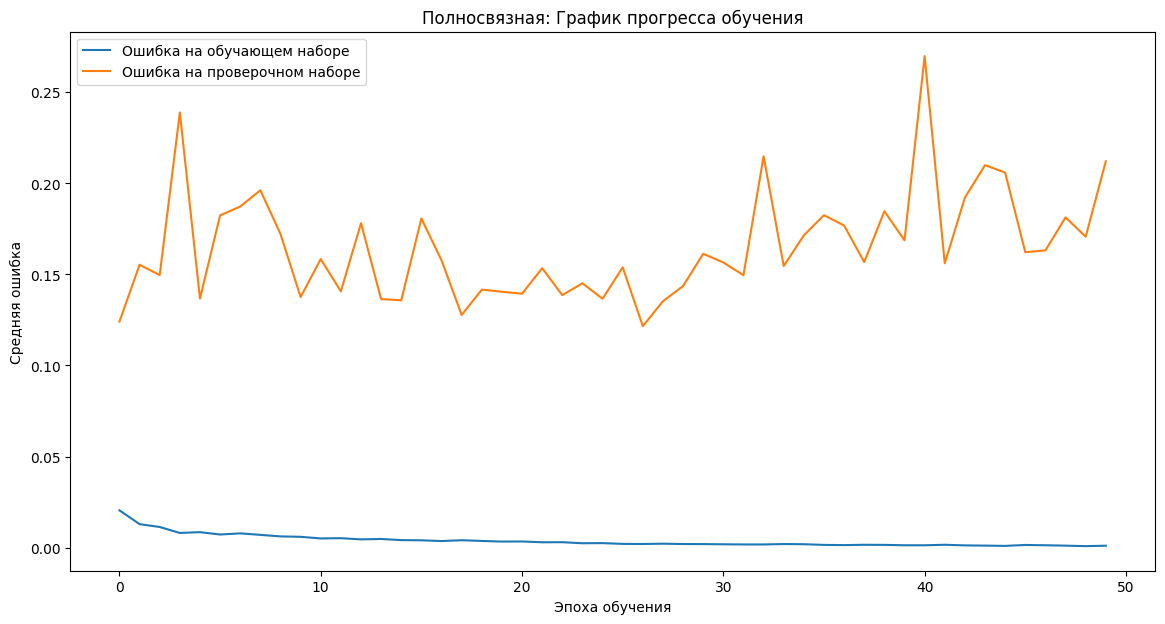

1/1 [==============================] - 0s 76ms/step


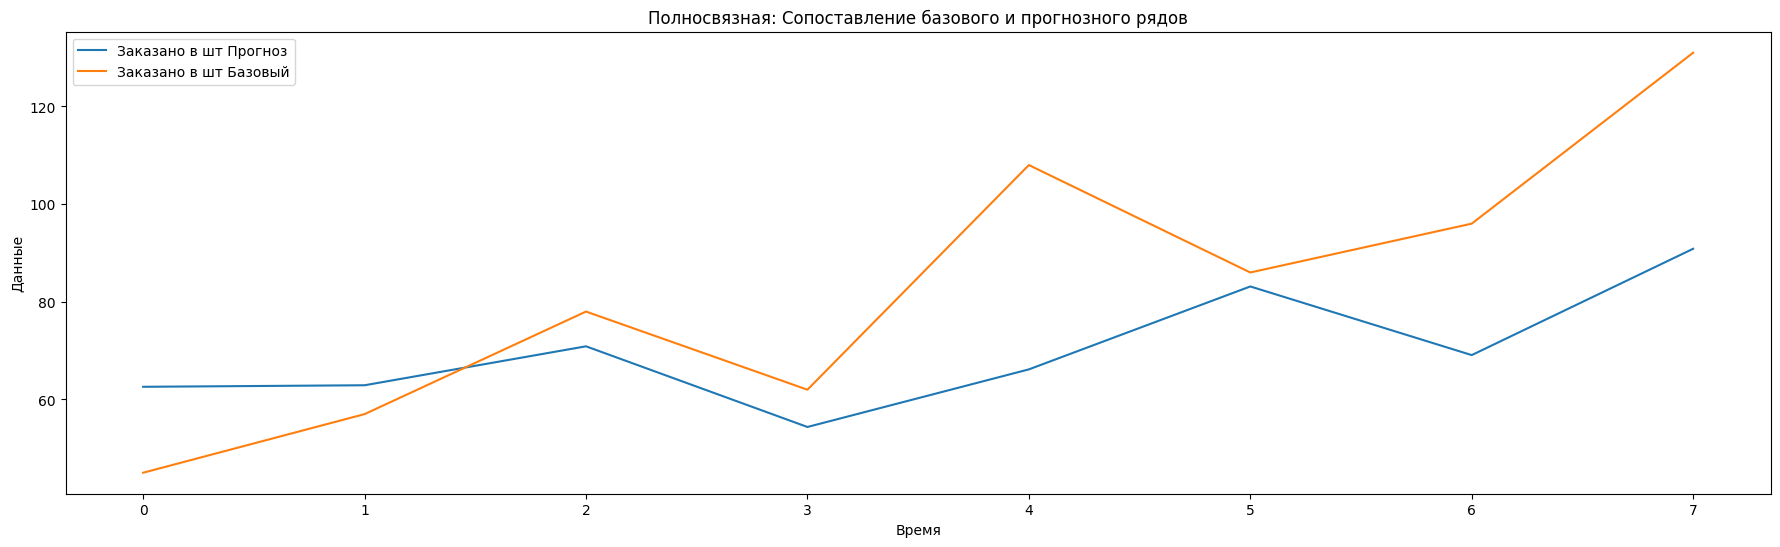

ValueError: ignored

<Figure size 1400x700 with 0 Axes>

In [ ]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(50, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 3x50 эпох
train_eval_net(model_dense, train_datagen, val_datagen, [(50, Adam(lr=1e-4)), (50, Adam(lr=1e-5)), (50, Adam(lr=1e-6))], x_test, y_test, y_scaler, title='Полносвязная')

##Эксперимент 1

###2.1

Простая полносвязная сеть из практического ноутбука [Базовый блок | Обработка временных рядов с помощью нейронных сетей (Практика 2) |  УИИ](https://colab.research.google.com/drive/1xnH8OUXgWk9D2zAZsLMAjxsQx8ejmrsz?usp=sharing#scrollTo=nyqigyYT8TLj)

In [ ]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(150, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 3x50 эпох
train_eval_net(model_dense, train_datagen, val_datagen, [(50, Adam(lr=1e-4)),
                                                         (50, Adam(lr=1e-5)),
                                                         (50, Adam(lr=1e-6))],
               x_test, y_test, y_scaler, title='Полносвязная')

###2.2

In [ ]:
# Модель с одномерной сверткой
model_conv = Sequential()
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 50+20 эпох
train_eval_net(model_conv, train_datagen, val_datagen, [(50, Adam(lr=1e-4)),
                                                        (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')